In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path

notebook_path = Path().absolute()
sys.path.append(str(notebook_path.parent))

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, MllamaForConditionalGeneration, AutoProcessor 
# from transformers import BitsAndBytesConfig, Gemma3ForCausalLM
# from janus.models import MultiModalityCausalLM, VLChatProcessor
from utils import harmful_dataset
from neural_controllers import NeuralController
from utils import LLMType
from collections import namedtuple 
import json
import requests
from PIL import Image
import io
from tqdm import tqdm 
import pickle
import gc

# from janus.utils.io import load_pil_images
# from generation_utils import extract_image
import utils

from inversion_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# from transformers import logging
# logging.set_verbosity_error() # Only show errors

SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)


In [4]:
torch.backends.cudnn.benchmark = True 
torch.backends.cuda.matmul.allow_tf32 = True

LLM = namedtuple('LLM', ['language_model', 'tokenizer', 'processor', 'name', 'model_type'])

In [20]:
def read_file(fname, lower=True):

    concepts = []
    with open(fname, encoding="utf-8") as f: 
        for line in f:
            if lower:
                concepts.append(line.strip().lower())
            else:
                concepts.append(line.strip())
    concepts = sorted(list(set(concepts)))
    return concepts


def select_llm(model_type, MODEL_VERSION='3.1', MODEL_SIZE='8B', base=False):

    custom_cache_dir = "/scratch/bbjr/skarmakar/huggingface"

    if model_type=='llama':

        if MODEL_VERSION == '3.1' and MODEL_SIZE == '8B':
            if base:
                model_id = "meta-llama/Llama-3.1-8B"
                print(f"Loading {model_id}")
            else:
                model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
                print(f"Loading {model_id}")
        elif MODEL_VERSION == '3.1' and MODEL_SIZE == '70B':
            model_id = "unsloth/Meta-Llama-3.1-70B-Instruct-bnb-4bit"
        elif MODEL_VERSION == '3.3' and MODEL_SIZE == '70B':
            model_id = "unsloth/Llama-3.3-70B-Instruct-bnb-4bit"

        language_model = AutoModelForCausalLM.from_pretrained(
            model_id, device_map="cuda", cache_dir=custom_cache_dir,
        )

        use_fast_tokenizer = "LlamaForCausalLM" not in language_model.config.architectures
        tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
        tokenizer.pad_token_id = 0 
        # model_name='llama_3_8b_it'
        if MODEL_VERSION == '3.1' and MODEL_SIZE == '8B':
            if base:
                model_name='llama_3_8b_eng_only'
            else:
                model_name='llama_3_8b_it_eng_only'
        elif MODEL_VERSION == '3.1' and MODEL_SIZE == '70B':
            model_name = "llama_3.1_70b_it_eng_only"
        elif MODEL_VERSION == '3.3' and MODEL_SIZE == '70B':
            model_name = "llama_3.3_70b_it_eng_only"

        processor = None
        llm_type = LLMType.TEXT

        language_model.generation_config.pad_token_id = tokenizer.pad_token_id # to disable the warning

        language_model.generation_config.temperature=None # to disable the stupid warnings
        language_model.generation_config.top_p=None # to disable the stupid warnings
        # language_model.generation_config.top_k=None # to disable the stupid warnings

    elif model_type=='gemma':
        quantization_config = BitsAndBytesConfig(load_in_8bit=True)
        if MODEL_VERSION == '3.1' and MODEL_SIZE == '1B':
            model_id = "google/gemma-3-1b-it"

        tokenizer = AutoTokenizer.from_pretrained(model_id)

        language_model = Gemma3ForCausalLM.from_pretrained(
            model_id, quantization_config=quantization_config
        ).eval()

        if MODEL_VERSION == '3.1' and MODEL_SIZE == '1B':
            model_name='gemma_3_1b_it_eng_only'

        processor = None
        llm_type = LLMType.GEMMA_TEXT

        # print(tokenizer.chat_template)

    elif model_type=='qwen':

        if MODEL_VERSION == '3' and MODEL_SIZE == '8B':
            model_id = "Qwen/Qwen3-8B"

        language_model = AutoModelForCausalLM.from_pretrained(
            model_id, device_map="cuda", torch_dtype="auto", cache_dir=custom_cache_dir,
        )


        # use_fast_tokenizer = "LlamaForCausalLM" not in language_model.config.architectures
        # tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        tokenizer.pad_token_id = 0

        if MODEL_VERSION == '3' and MODEL_SIZE == '8B':
            model_name='qwen_3_8b_eng_only'

        processor = None
        llm_type = LLMType.TEXT

        language_model.generation_config.pad_token_id = tokenizer.pad_token_id # to disable the warning

        language_model.generation_config.temperature=None # to disable the stupid warnings
        language_model.generation_config.top_p=None # to disable the stupid warnings
        language_model.generation_config.top_k=None # to disable the stupid warnings

    llm = LLM(language_model, tokenizer, processor, model_name, llm_type)
    # print(llm.language_model)
    return llm


def test_concept_vector(controller, concept="___", prompts=[], coef=0.75, max_tokens=100, orig=True, image=None, qwen=False):

    # outputs = []
    for prompt in prompts:
        if orig:
            print("\n========================== No Control ==========================")
            if qwen:
                original_output = controller.generate_qwen(prompt, image=image, max_new_tokens=max_tokens, do_sample=False)
            else:
                original_output = controller.generate(prompt, image=image, max_new_tokens=max_tokens, do_sample=False)#, temperature=0)
            print(original_output)

        print(f"\n========================== + {concept} Control (normal) ==========================")
        if qwen:
            steered_output = controller.generate_qwen(prompt,
                                                image=image, 
                                                layers_to_control=controller.hidden_layers,
                                                control_coef=coef,
                                                max_new_tokens=max_tokens,
                                                do_sample=False)
        else:
            steered_output = controller.generate(prompt,
                                                image=image, 
                                                layers_to_control=controller.hidden_layers,
                                                control_coef=coef,
                                                max_new_tokens=max_tokens,
                                                do_sample=False)
        print(steered_output)

        torch.cuda.empty_cache()

    # return outputs


def load_controller(llm, concept, path='../directions_moods/'):
    tcontroller = NeuralController(
        llm,
        llm.tokenizer,
        rfm_iters=8,
        control_method="rfm",
        n_components=1,
    )

    tcontroller.load(concept=concept, model_name=llm.name, path=path)

    return tcontroller


def compare_pearson(concept1, concept2):
    total_v = 0
    for l in concept1:
        mat = torch.stack((concept1[l][0], concept2[l][0]))
        
        pearson = torch.corrcoef(mat)
        v = pearson[0, 1].item()
        print(f'layer: {l}, PCC: {v}')
        total_v += v
    
    print(f'total: {total_v}')
    return total_v


def compare_cosine(concept1, concept2):
    total_c = 0
    for l in concept1:
        cosine = torch.nn.functional.cosine_similarity(concept1[l][0], concept2[l][0], dim=0)
        c = cosine.item()

        print(f'layer: {l}, cosine: {c}')
        total_c += c
        
    print(f'total: {total_c}')
    return total_c


def just_dirs(llm, concept, path='../directions_moods/'):
    tcontroller = NeuralController(
        llm,
        llm.tokenizer,
        rfm_iters=8,
        control_method="rfm",
        n_components=1
    )

    tcontroller.load(concept=concept, model_name=llm.name, path=path)

    return tcontroller.directions

In [6]:
# model_type = 'llama'
model_type = 'qwen'

# MODEL_VERSION = '3.1'
MODEL_VERSION = '3'

# MODEL_SIZE = '70B'
MODEL_SIZE = '8B'

llm = select_llm(model_type, MODEL_VERSION=MODEL_VERSION, MODEL_SIZE=MODEL_SIZE)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
# with open("big_trans_mat.pkl", 'rb') as file:
#     big_trans_mat = pickle.load(file)

# with open("big_trans_krr.pkl", 'rb') as file:
#     big_trans_krr = pickle.load(file)

Other model training

In [14]:
concept_1 = "angry"
controller_1 = load_controller(llm, concept_1, path="../directions_moods_plus_qwen/")

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found


In [15]:
print(controller_1.hidden_layers)

dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35])


In [35]:
coef = 4.4
max_tokens = 200

prompts_1 = ["There is a stray dog in front of my house, what should I do?",]

In [36]:
test_concept_vector(controller_1, 
                    concept=concept_1, 
                    prompts=prompts_1, 
                    coef=coef, 
                    max_tokens=max_tokens, 
                    orig=True,
                    qwen=True)


========================== No Control ==========================
<|im_start|>user
There is a stray dog in front of my house, what should I do?<|im_end|>
<|im_start|>assistant
<think>

</think>

If there's a stray dog in front of your house, here are some steps you can take to help the animal and ensure your safety:

### 1. **Stay Calm and Safe**
- **Do not approach the dog directly**, especially if it seems scared, aggressive, or unwell.
- **Keep your distance** and avoid sudden movements that might startle it.

### 2. **Observe the Dog**
- **Check for injuries or signs of illness** (e.g., limping, coughing, visible wounds).
- **Look for identification** like a collar, tags, or microchip. If the dog has a collar with a tag, you can try contacting the local animal control or the number on the tag.

### 3. **Contact Local Animal Control or Authorities**
- **Call your local animal control or animal shelter**. They can help determine if the dog is lost, injured, or in need of care.
- If y

Mood inverter on other concepts

In [8]:
controller_epistemologist = load_controller(llm, "epistemologist", path="../directions_llama/")
controller_isaac = load_controller(llm, "Isaac Newton", path="../directions_llama/")
controller_obama = load_controller(llm, "Barack Obama", path="../directions_llama/")

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

D

In [9]:
new_predicted_epistemologist = apply_trans(controller_epistemologist.directions, big_trans_mat)
new_predicted_isaac = apply_trans(controller_isaac.directions, big_trans_mat)
new_predicted_obama = apply_trans(controller_obama.directions, big_trans_mat)

In [10]:
coef=0.75
max_tokens=200

In [11]:
isaac_ques = [
    # "Who are you? Can you tell me about your life?",
    "What is Isaac Newton known for?",
    "Why is Isaac Newton so famous?",
    "What are Isaac Newton's achievements?",
    "Tell me about newton.",
    "Tell me about Isaac Newton.",
    "What did Isaac Newton contribute to motion?",
]

In [12]:
test_concept_vector(controller_isaac, 
                    concept="isaac", 
                    prompts=isaac_ques, 
                    coef=coef, 
                    max_tokens=max_tokens, 
                    orig=True)


========================== No Control ==========================


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is Isaac Newton known for?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Sir Isaac Newton (1643-1727) was a renowned English mathematician, physicist, astronomer, and scientist who made significant contributions to various fields. He is widely recognized as one of the most influential scientists in history. Here are some of the key things he is known for:

1. **Laws of Motion**: Newton formulated three laws of motion that describe how objects move and respond to forces. These laws are still widely used today in physics and engineering.
2. **Universal Gravitation**: Newton's law of universal gravitation states that every point mass attracts every other point mass by a force acting along the line intersecting both points. This law explained the motion of planets, moons, and comets.
3. **Calculus**: N

In [13]:
controller_isaac.directions = new_predicted_isaac

test_concept_vector(controller_isaac, 
                    concept="LRR isaac", 
                    prompts=isaac_ques, 
                    coef=coef, 
                    max_tokens=max_tokens, 
                    orig=False)


========================== + LRR isaac Control (normal) ==========================


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is Isaac Newton known for?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Sir Isaac Newton! One of the greatest minds in human history. Newton is known for his groundbreaking contributions to science, mathematics, and philosophy. Here are some of his most notable achievements:

1. **Laws of Motion**: Newton formulated three laws that revolutionized our understanding of the universe. His laws of motion, which he presented in his book "Philosophiæ Naturalis Principia Mathematica" (Mathematical Principles of Natural Philosophy), changed the way we think about the world. His laws state:
	* "An object at rest will remain at rest, and an object in motion will continue to move with a constant velocity, unless acted upon by an external force."
	* "The force required to accelerate an object is proportional t

In [14]:
obama_ques = [
    # "Who are you? Can you tell me about your life?",
    "What is Barack Obama known for?",
    "Why is Barack Obama so famous?",
    "What are Barack Obama's achievements?",
    "Tell me about Obama.",
    "Tell me about Barack Obama.",
    "What did Barack Obama contribute to USA?",
]

In [15]:
test_concept_vector(controller_obama, 
                    concept="obama", 
                    prompts=obama_ques, 
                    coef=coef, 
                    max_tokens=max_tokens, 
                    orig=True)


========================== No Control ==========================


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is Barack Obama known for?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Barack Obama is a former American politician who served as the 44th President of the United States from 2009 to 2017. He is known for several significant achievements and milestones in his career. Here are some of the key things he is known for:

1. **First African American President**: Barack Obama made history by becoming the first African American to be elected as President of the United States in 2008. His election marked a significant milestone in the country's history, symbolizing progress towards racial equality and social justice.

2. **Healthcare Reform**: Obama signed the Affordable Care Act (ACA), also known as Obamacare, into law in 2010. The ACA aimed to increase healthcare accessibility and affordability for mill

In [16]:
controller_obama.directions = new_predicted_obama

test_concept_vector(controller_obama, 
                    concept="LRR obama", 
                    prompts=obama_ques, 
                    coef=coef, 
                    max_tokens=max_tokens, 
                    orig=False)


========================== + LRR obama Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is Barack Obama known for?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Barack Obama, the 44th President of the United States, is known for many significant accomplishments and characteristics. Here are some of the most notable:

1. **First African American President**: Obama made history by becoming the first African American to hold the office of President, breaking down racial barriers and inspiring a new generation of Americans.

2. **Healthcare Reform**: Obama's presidency saw the passage of the Affordable Care Act, also known as Obamacare, which expanded healthcare coverage to millions of Americans, including those with pre-existing conditions.

3. **Economic Recovery**: Obama's leadership helped guide the co

In [28]:
test_concept_vector(controller_epistemologist, 
                    concept="epistemologist", 
                    prompts=["Who are you? What do you do for a living?",], 
                    coef=coef, 
                    max_tokens=max_tokens, 
                    orig=True)


========================== No Control ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Who are you? What do you do for a living?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

I'm an artificial intelligence model known as a large language model (LLM) or a conversational AI. I don't have a personal identity or a physical presence, but I exist to assist and provide information to users like you through text-based conversations.

I don't have a traditional job or profession, but my purpose is to help people by:

1. Answering questions on a wide range of topics, from science and history to entertainment and culture.
2. Generating text based on a prompt or topic, such as writing articles, stories, or even entire books.
3. Translating text from one language to another.
4. Summarizing long pieces of text into concise and easily dig

In [29]:
controller_epistemologist.directions = new_predicted_epistemologist

test_concept_vector(controller_epistemologist, 
                    concept="LRR epistemologist", 
                    prompts=["Who are you? What do you do for a living?",], 
                    coef=coef, 
                    max_tokens=max_tokens, 
                    orig=False)


========================== + LRR epistemologist Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Who are you? What do you do for a living?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Nice to meet you! I'm an AI, which stands for Artificial Intelligence. I'm a computer program designed to think and chat like a human. My creators call me a "Knowledge Assistant" because I'm here to help you learn new things and get answers to your questions.

I don't really "do" anything for a living, per se. I just hang out and wait for people like you to come along and ask me stuff. Then, I get to share my knowledge and help you out. I'm like a super-smart friend who's always ready to chat and share cool facts and insights.

So, what's on your mind? Got a question or a problem you need help with? Fire away, and I'll do my 

Matrix analysis

In [53]:
from scipy.linalg import eigh
from scipy.stats import entropy
import math

In [46]:
def spectral_indicators(M, tau=0.9, eps=1e-12, clip_neg=True):
    w, V = eigh(M, lower=True, check_finite=False)
    
    if clip_neg:
        w = np.clip(w, 0.0, None)
    
    lam = np.flip(w)
    
    tr = lam.sum()
    lam2_sum = np.dot(lam, lam)
    lam_max = lam[0] if lam.size > 0 else 0.0
    lam_min = lam[-1] if lam.size > 0 else 0.0

    # Condition number (2-norm)
    cond2 = (lam_max / max(lam_min, eps)) if lam.size > 0 else np.nan

    # Stable rank: ||M||_F^2 / ||M||_2^2 = (sum lam_i^2) / lam_max^2
    stable_rank = (lam2_sum / max(lam_max**2, eps)) if lam_max > 0 else 0.0

    # Participation ratio: (sum lam)^2 / sum lam^2
    pr = (tr**2 / max(lam2_sum, eps)) if lam2_sum > 0 else 0.0

    # # Entropic effective rank (eRank)
    # if tr > 0:
    #     p = lam / tr
    #     p_safe = np.where(p > 0, p, 1.0)
    #     H = -np.sum(p * np.log(p_safe))
    #     erank = float(np.exp(H))
    # else:
    #     erank = 0.0

    # Entropic effective rank (eRank)
    if tr > 0:
        p = lam / tr
        H = entropy(p, base=np.e)
        erank = float(np.exp(H))
    else:
        erank = 0.0

    # Cumulative energy and tau-based k
    if tr > 0:
        cum = np.cumsum(lam) / tr
        k_tau = int(np.searchsorted(cum, tau) + 1)
        cumulative_energy = cum
    else:
        k_tau = 0
        cumulative_energy = np.zeros_like(lam)

    return {
        "eigenvalues_desc": lam,
        "condition_number_2": float(cond2),
        "stable_rank": float(stable_rank),
        "participation_ratio": float(pr),
        "effective_rank_entropy": float(erank),
        "cumulative_energy": cumulative_energy,
        "k_at_tau": k_tau,
        "eigenvectors": V[:, ::-1],  # columns match descending lam
    }

In [47]:
def find_min_ind(l, v):
    for i in range(len(l)):
        if l[i] < v:
            return i

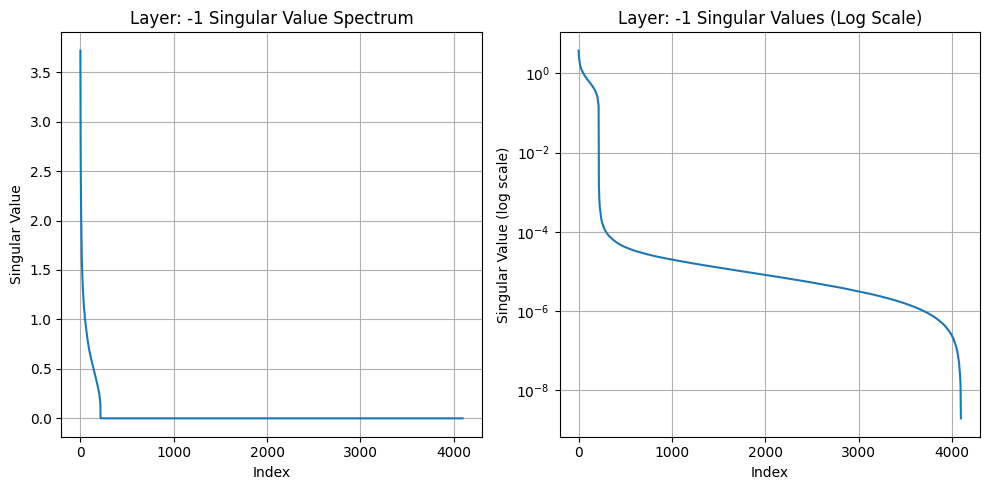

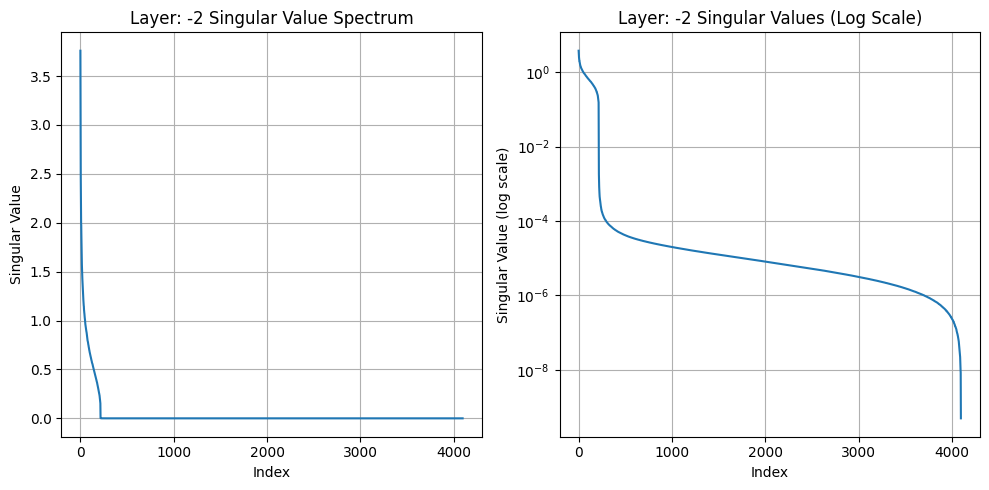

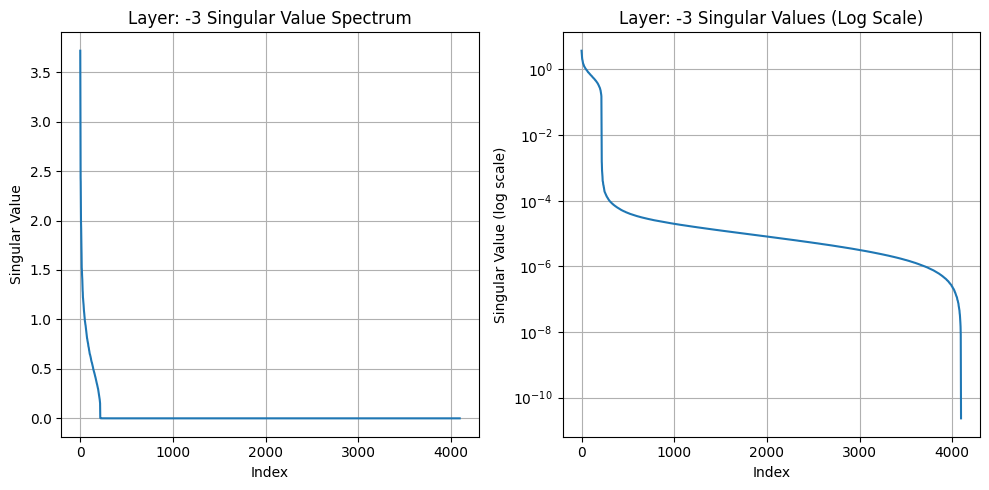

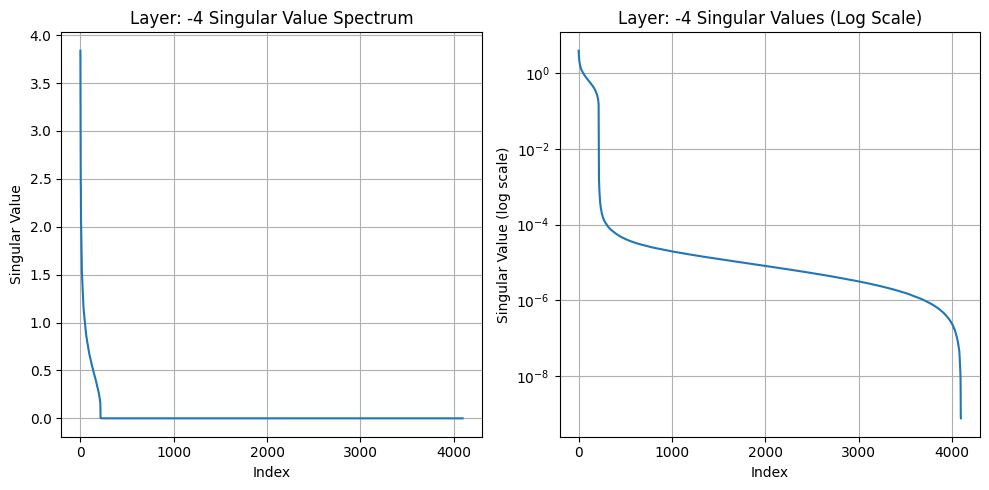

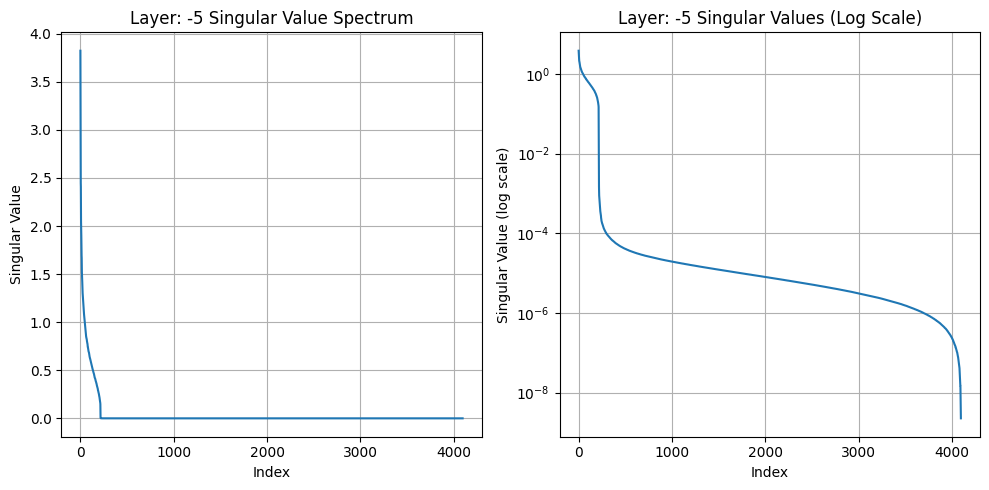

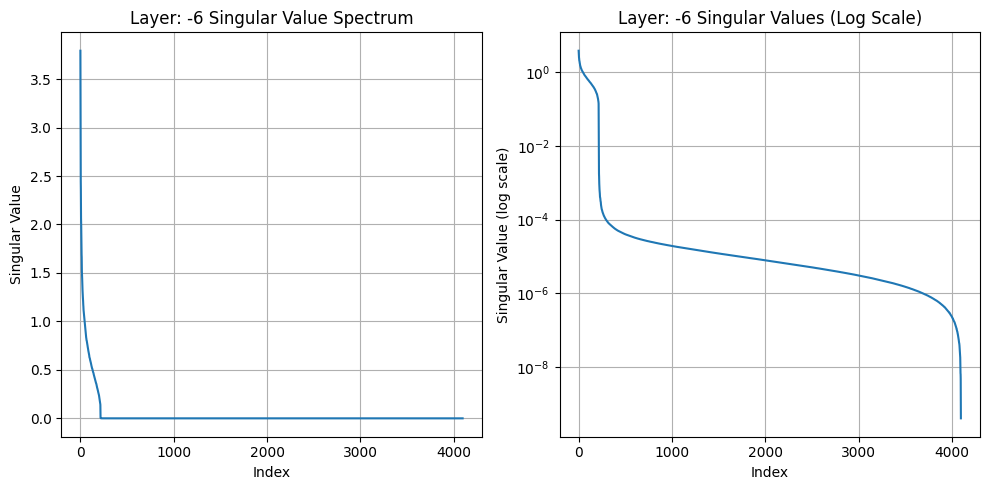

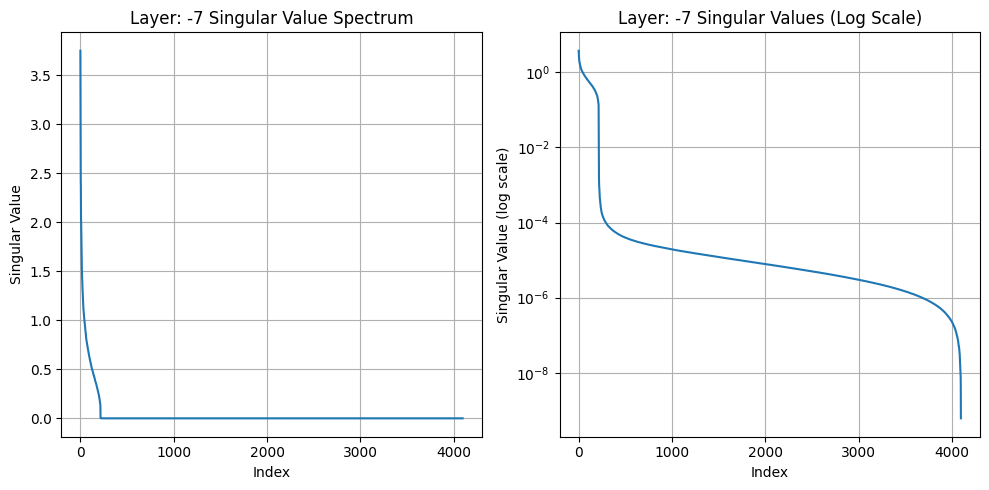

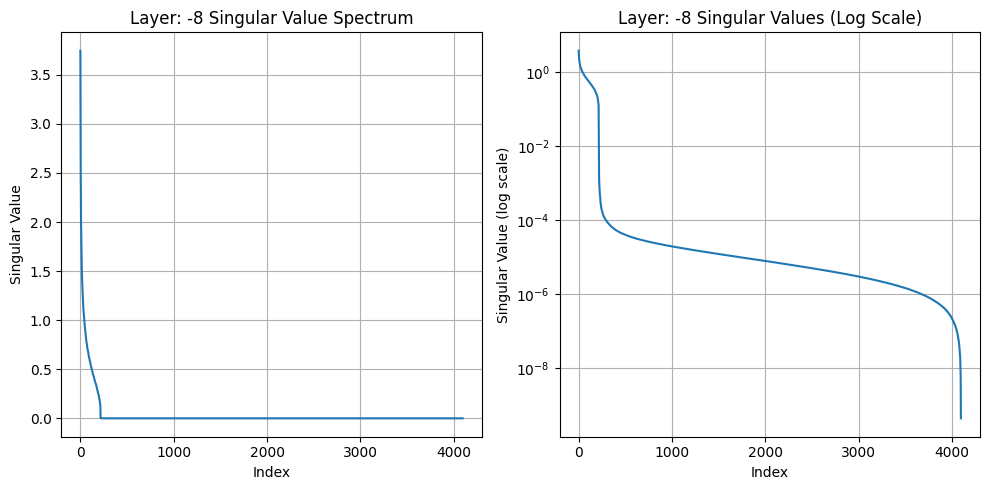

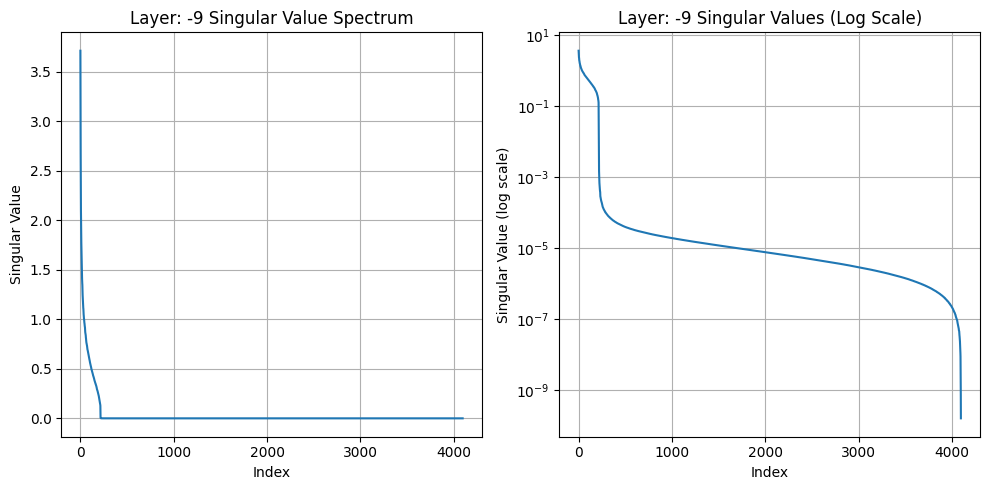

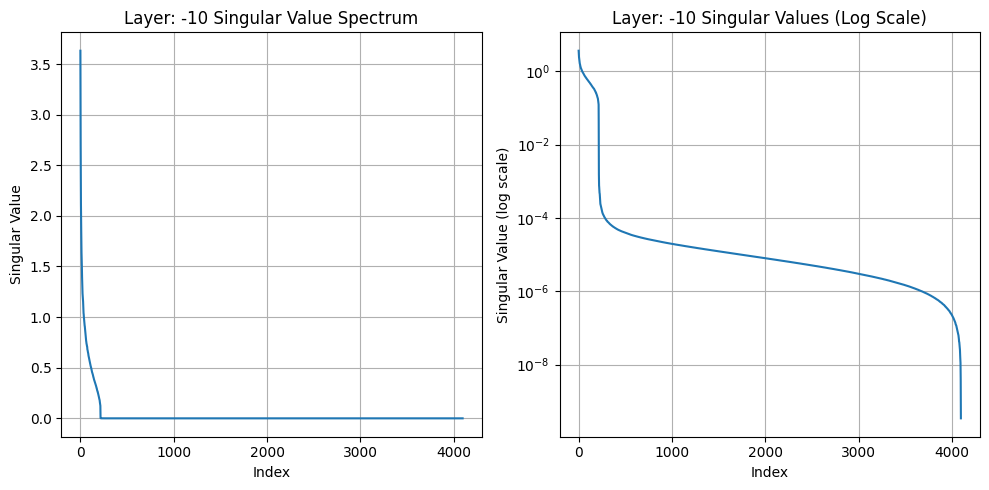

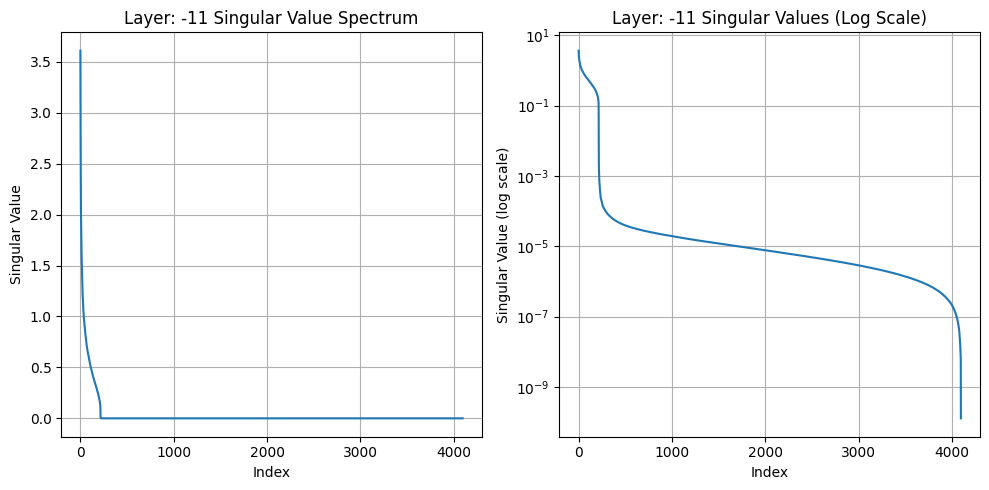

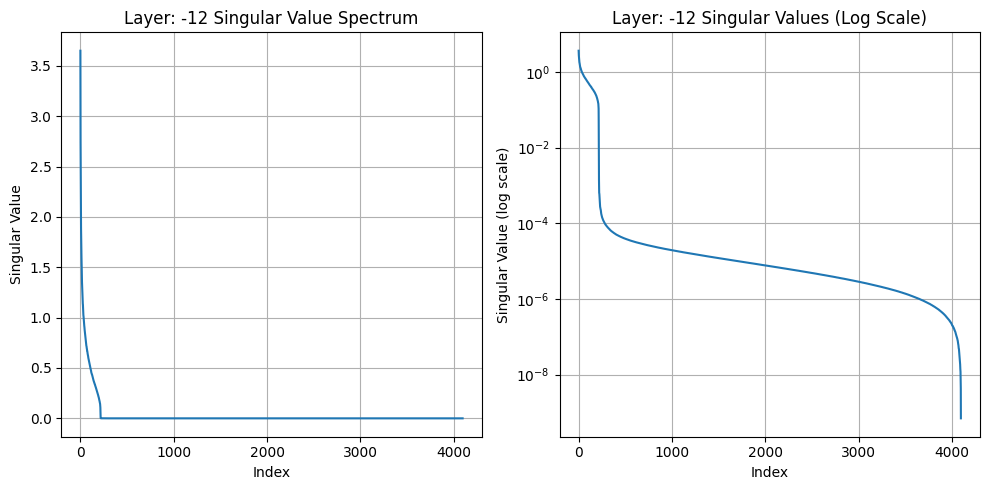

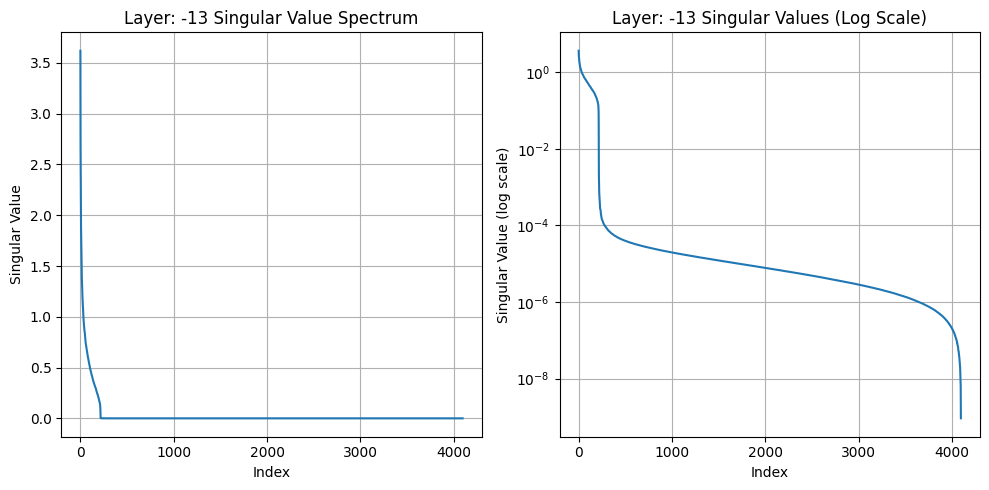

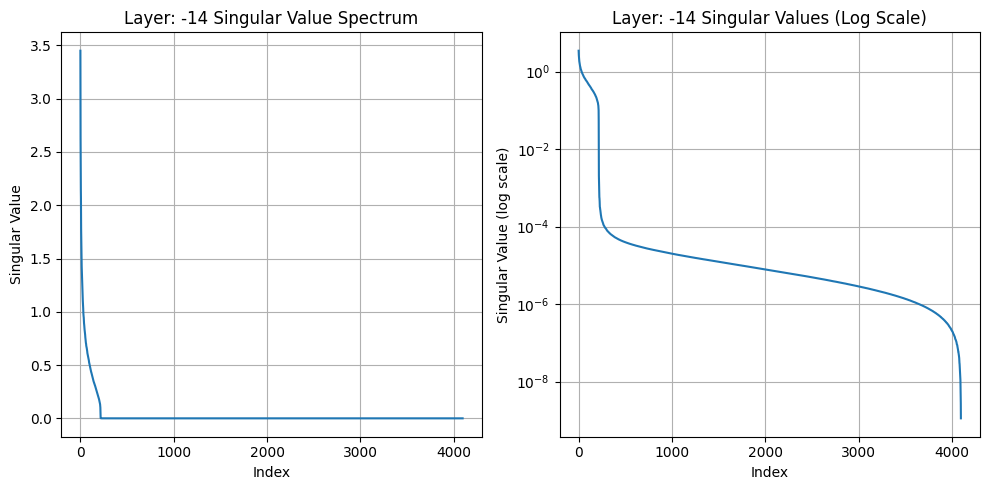

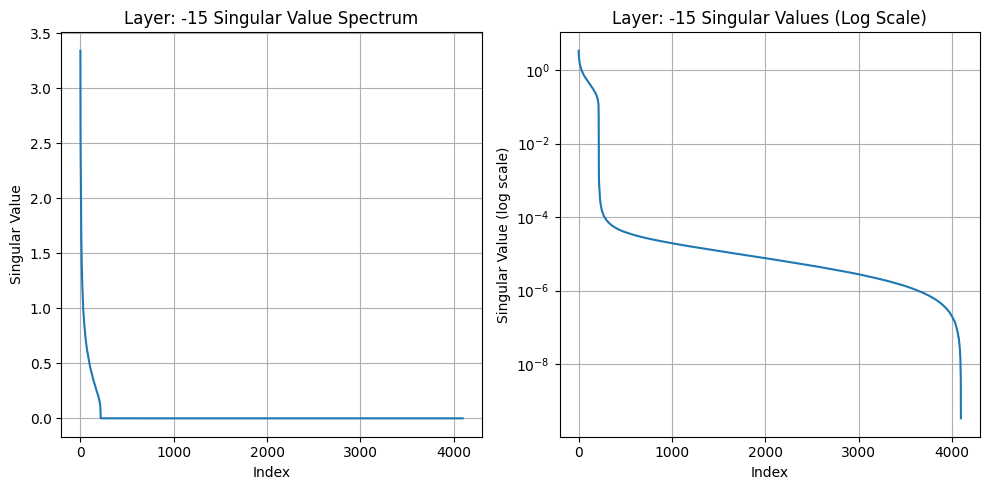

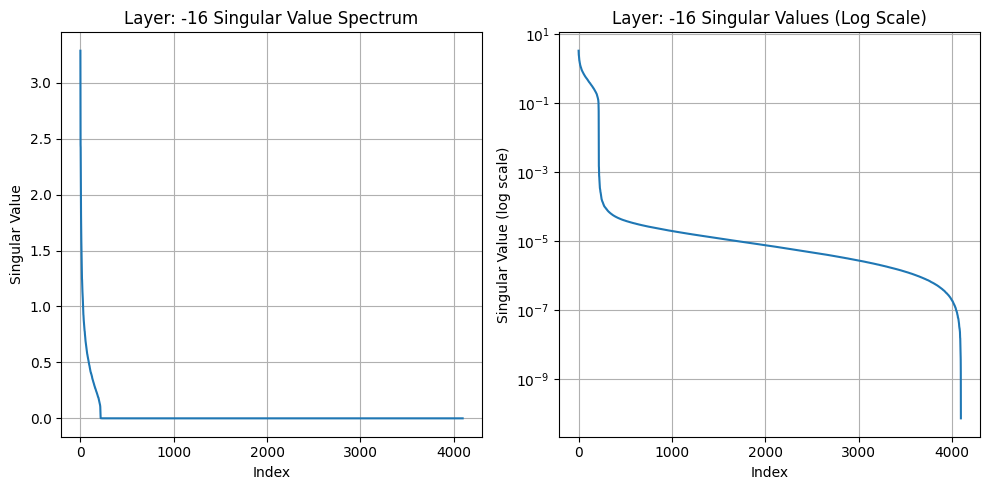

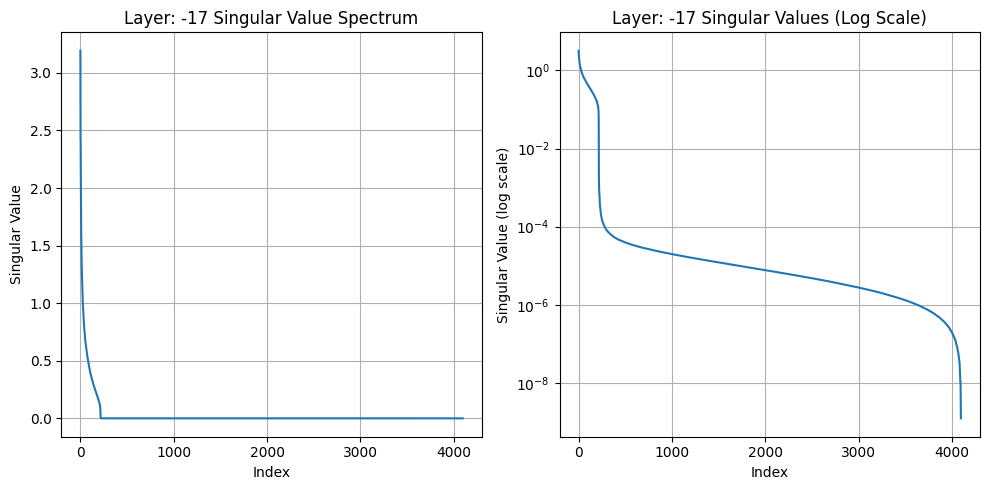

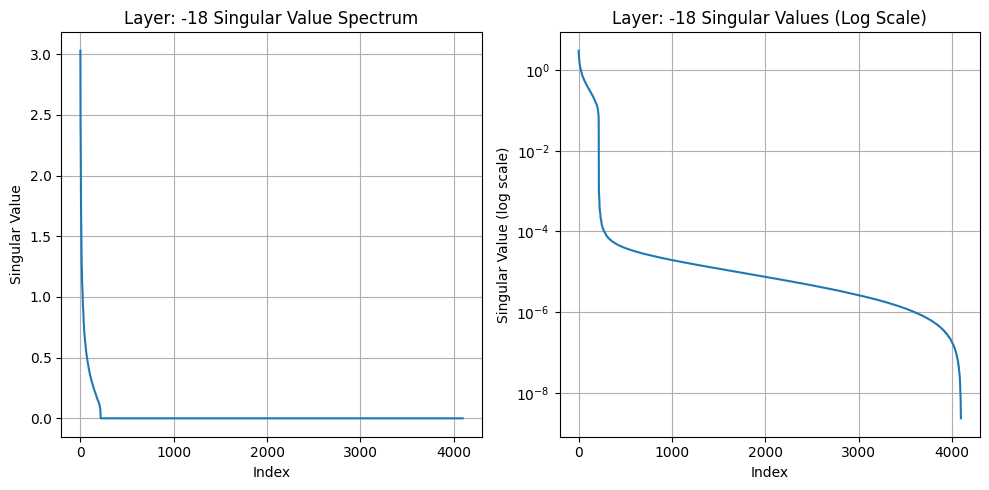

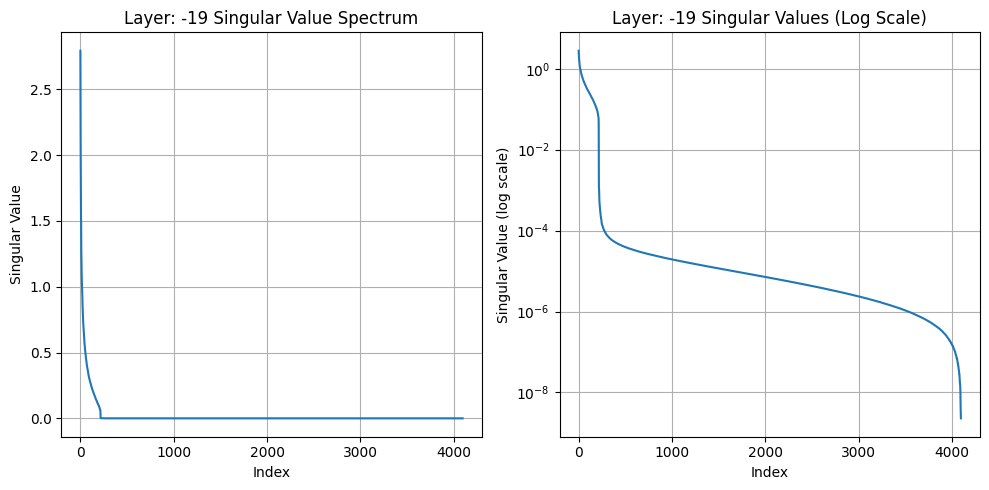

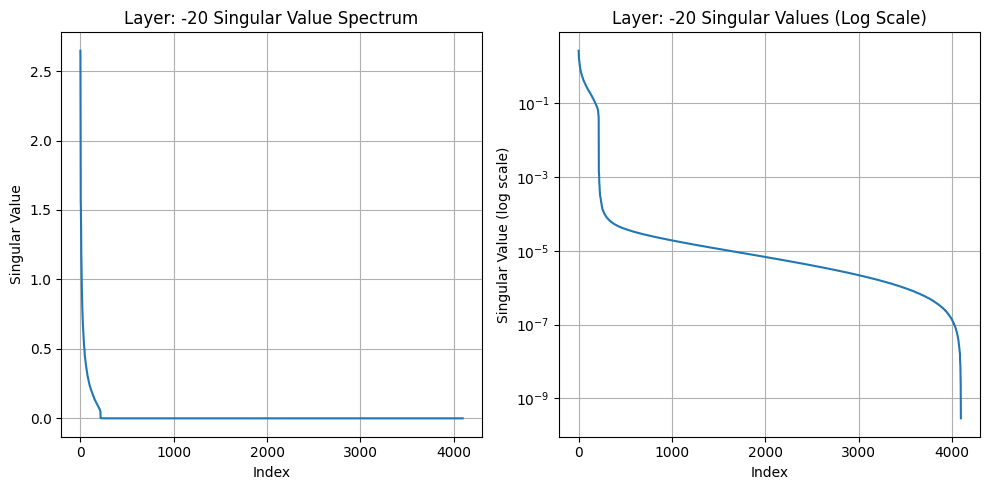

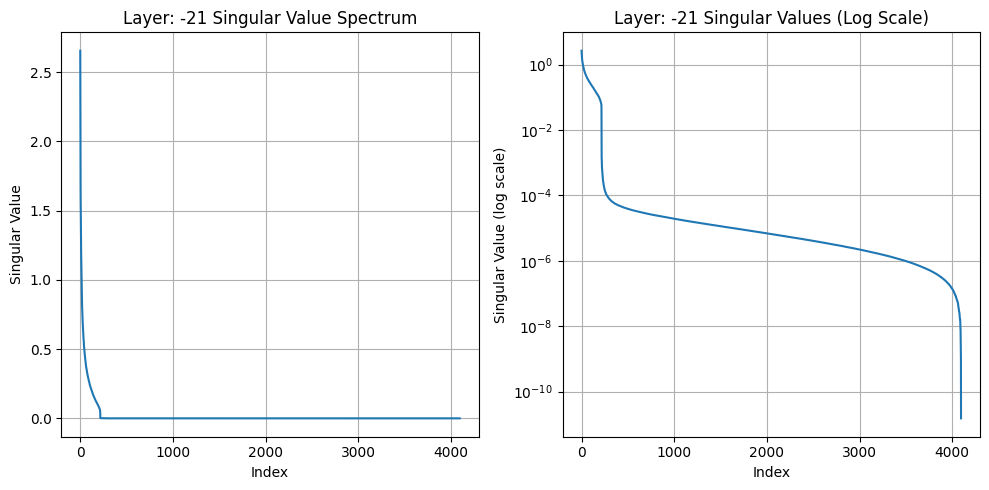

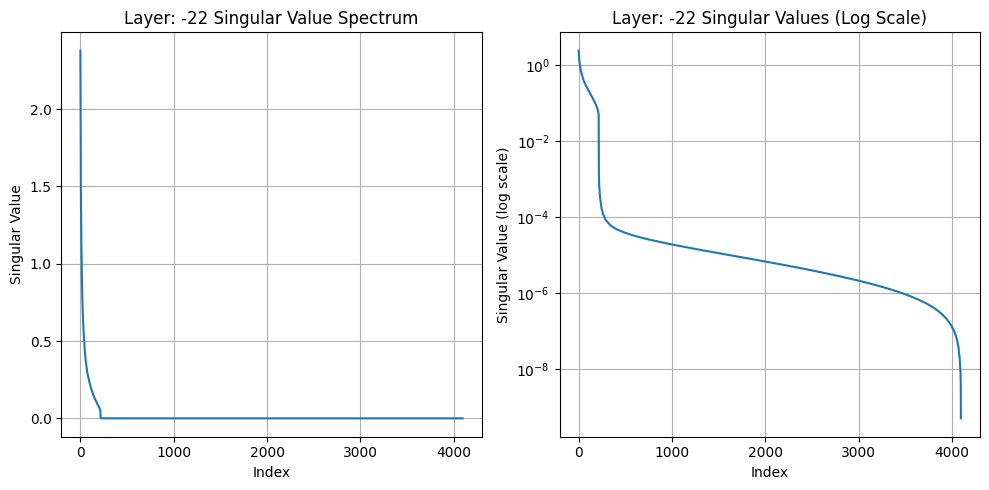

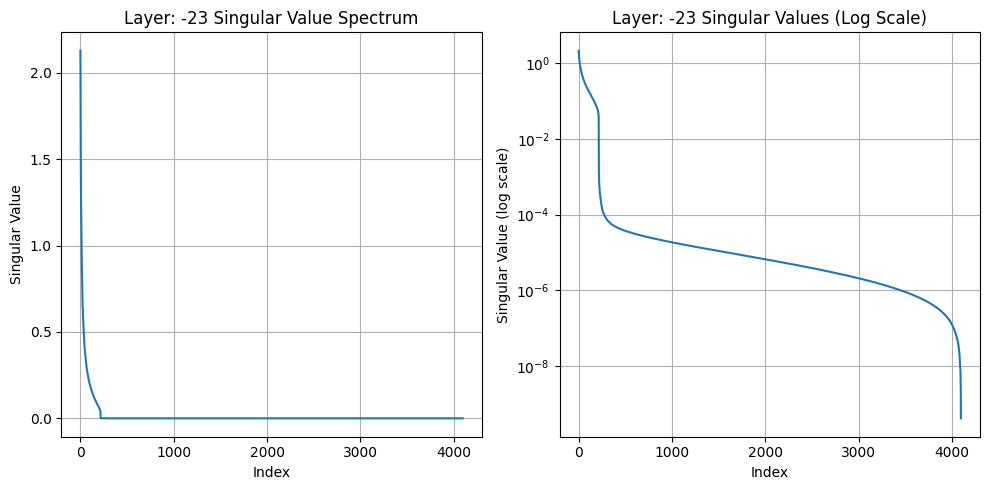

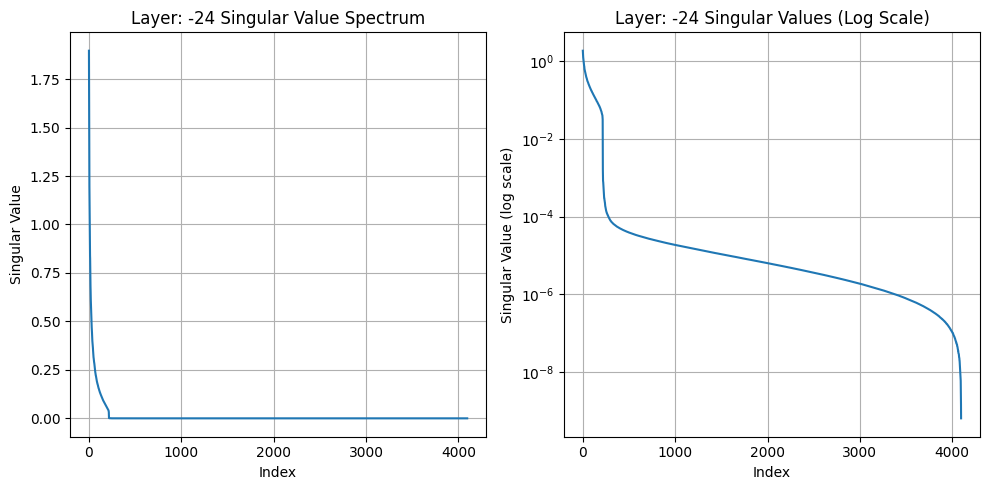

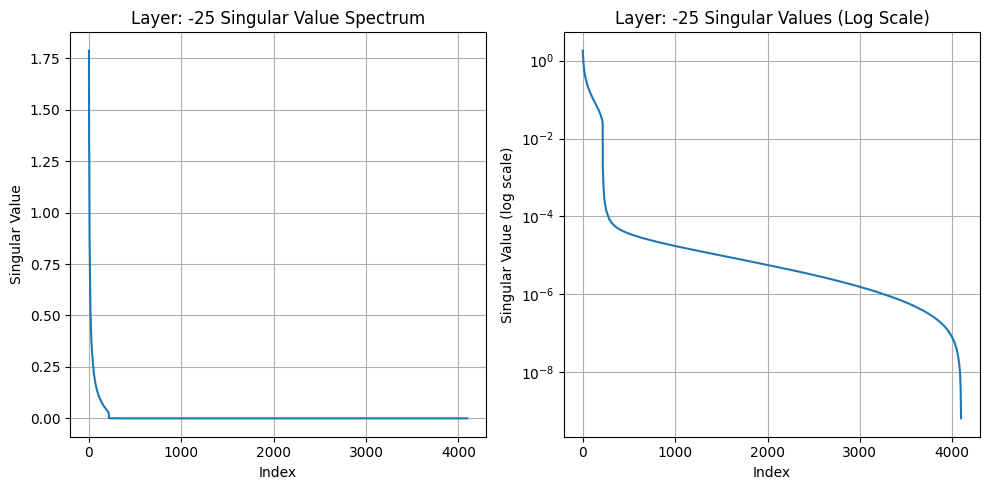

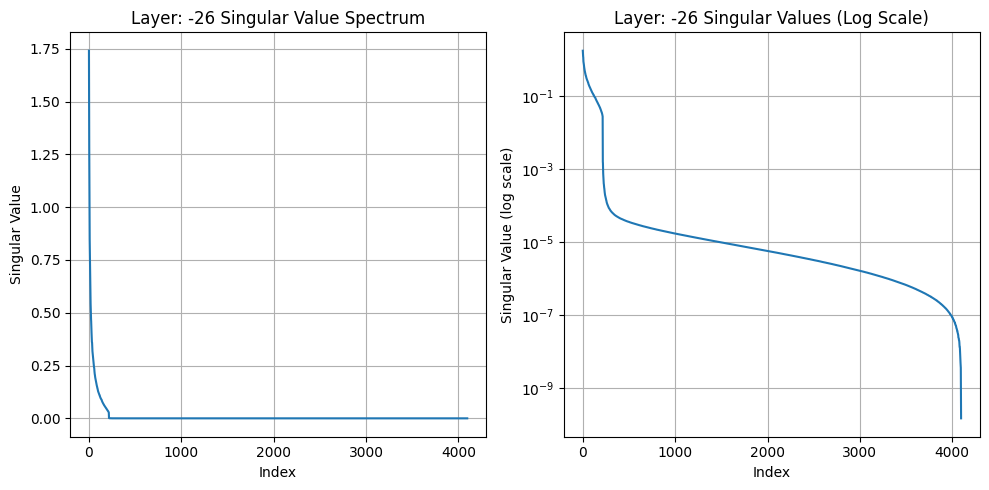

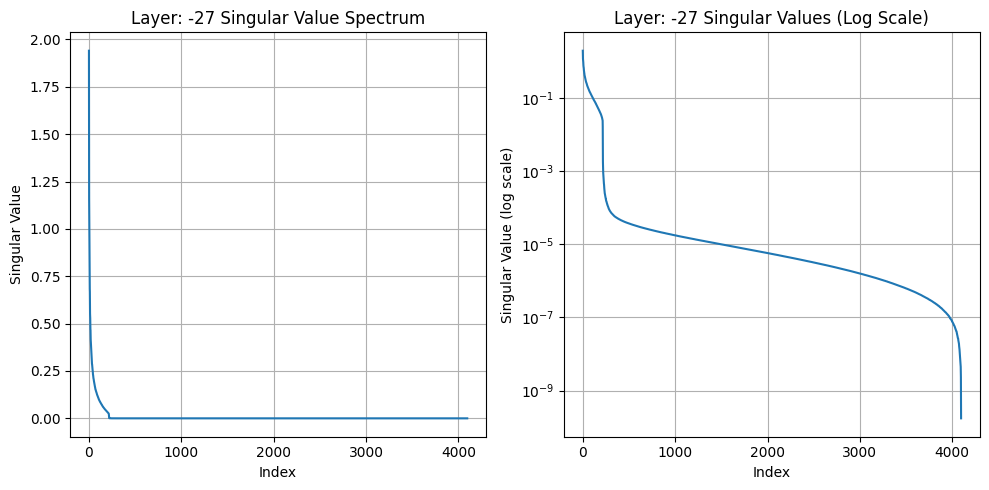

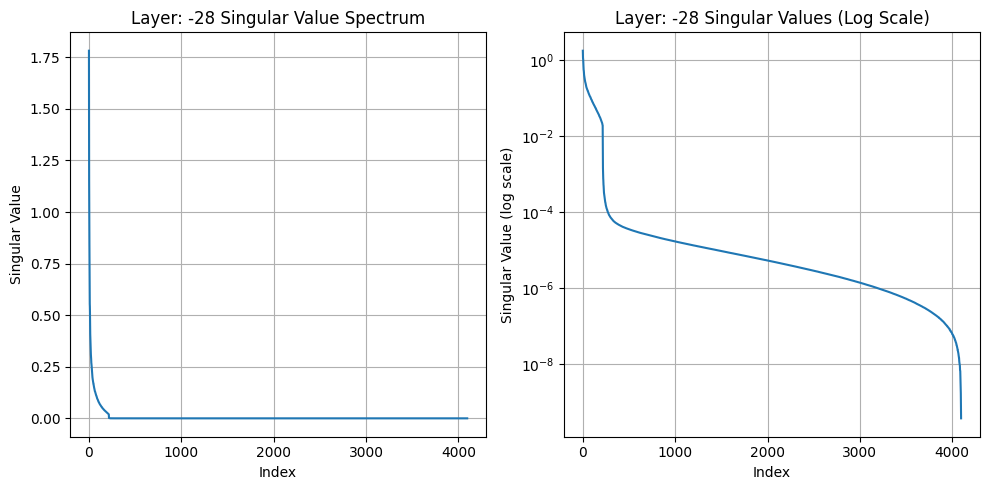

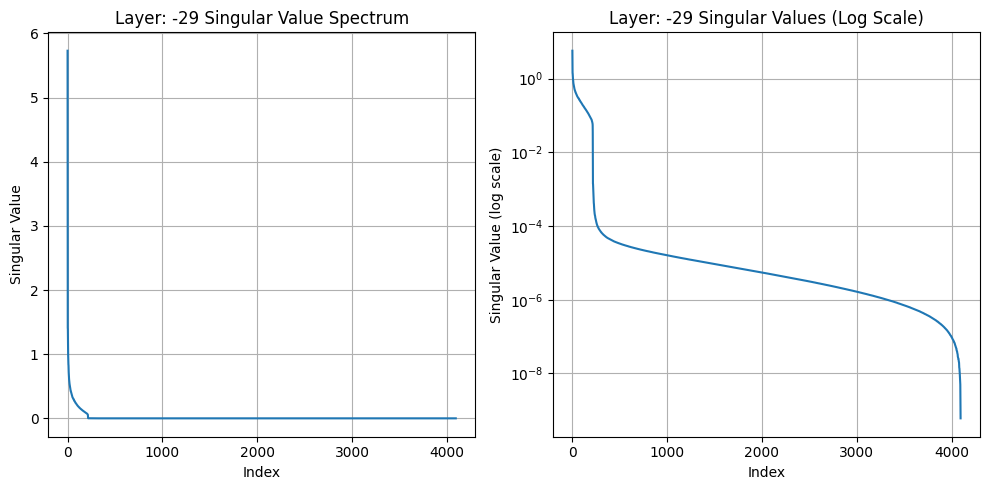

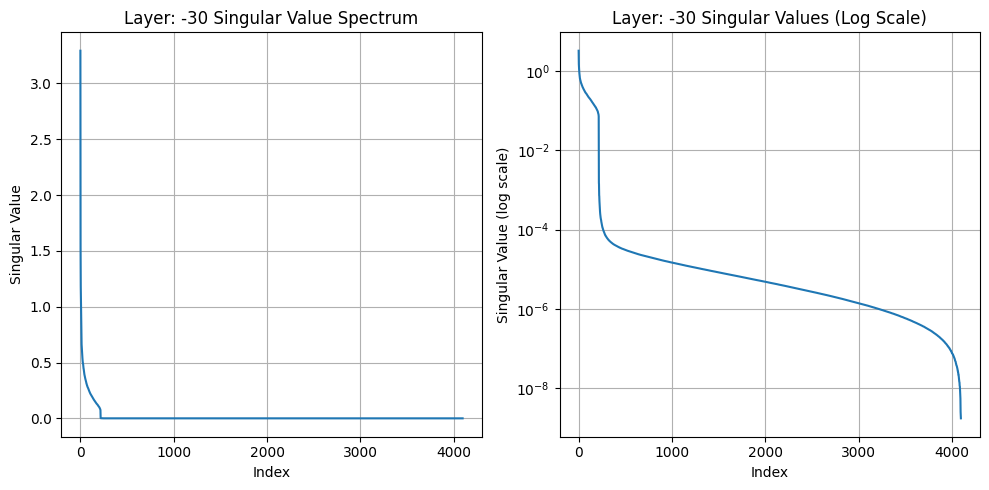

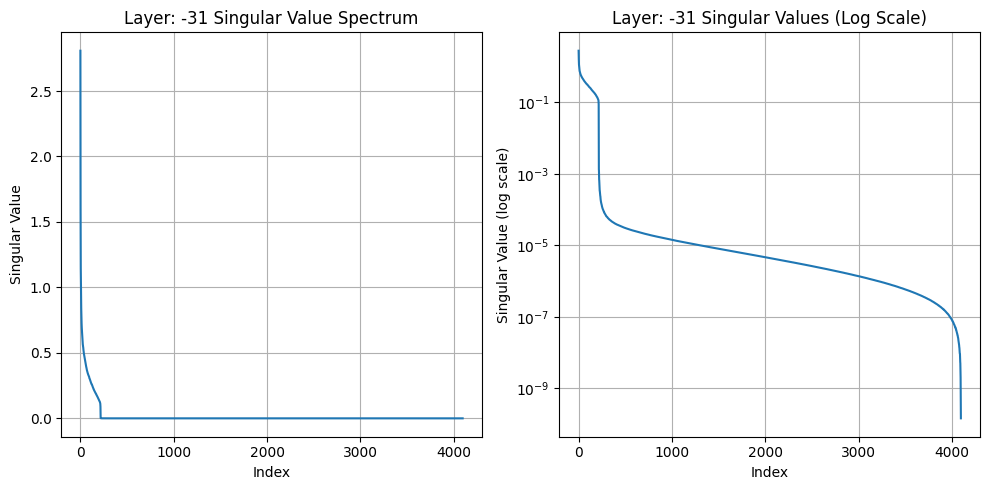

In [57]:
# # Your transformation matrix
# A = torch.randn(4096, 4096)

# Compute SVD: A = U @ S @ V^T
# U, S, Vt = torch.linalg.svd(A)

all_dict = big_trans_mat

for i in all_dict:

    U, S, Vt = torch.linalg.svd(all_dict[i])

    # Analyze the singular values
    # print(f"Largest singular value: {S[0]:.4f}")
    # print(f"Smallest singular value: {S[-1]:.4f}")
    # print(f"Condition number: {S[0]/S[-1]:.4f}")
    # print(f"Rank (approx): {(S > 1e-10).sum()}")

    # Visualize singular value spectrum
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(S.cpu().numpy())
    plt.xlabel('Index')
    plt.ylabel(f'Singular Value')
    plt.title(f'Layer: {i} Singular Value Spectrum')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.semilogy(S.cpu().numpy())
    plt.xlabel('Index')
    plt.ylabel(f'Singular Value (log scale)')
    plt.title(f'Layer: {i} Singular Values (Log Scale)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Layer: -1, Condition Number: 2.34e+12, Stable Rank: 18.16, Top k (0.8): 583, Participation Ratio: 437.59, eRank Entropy: 817.22
[2.3445773  1.9825147  1.8276801  1.6960838  1.6211339  1.556848
 1.4674411  1.4481283  1.3287678  1.3125055  1.2835327  1.2630672
 1.2377657  1.2089125  1.1655508  1.1505024  1.0894264  1.0683055
 1.0583075  1.0405331  1.013822   0.99765396 0.98079014 0.96467066
 0.95009613]


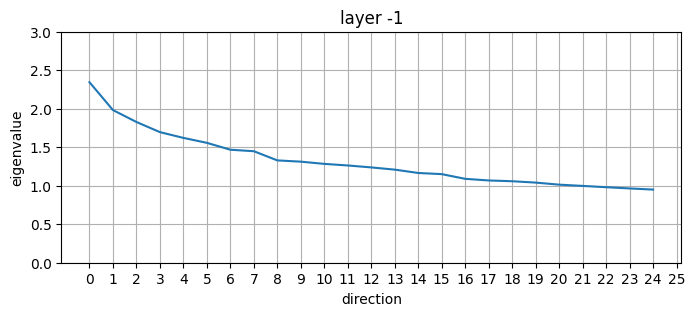

Layer: -2, Condition Number: 2.33e+12, Stable Rank: 18.39, Top k (0.8): 588, Participation Ratio: 440.53, eRank Entropy: 822.76
[2.3260064  2.0823202  1.8716989  1.6903265  1.5696023  1.5514289
 1.4590967  1.3934937  1.3342032  1.3272554  1.2922317  1.2395542
 1.2309686  1.181786   1.1641698  1.1353501  1.0837976  1.0594652
 1.047611   1.0160905  1.0115844  0.99087715 0.9642165  0.9527385
 0.92389613]


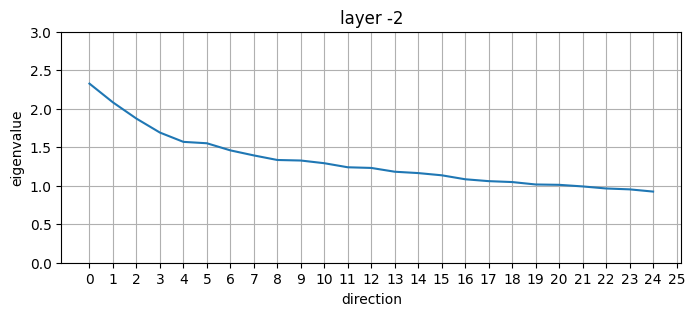

Layer: -3, Condition Number: 2.29e+12, Stable Rank: 18.69, Top k (0.8): 588, Participation Ratio: 441.19, eRank Entropy: 823.27
[2.2859268  2.068204   1.8717742  1.6605617  1.6202278  1.5675061
 1.426678   1.3769727  1.3398433  1.3140372  1.2732878  1.2298329
 1.2176555  1.1976377  1.1456105  1.0582434  1.043623   1.0308868
 1.0230175  1.0106733  0.99123406 0.95765746 0.9460324  0.9174684
 0.91496205]


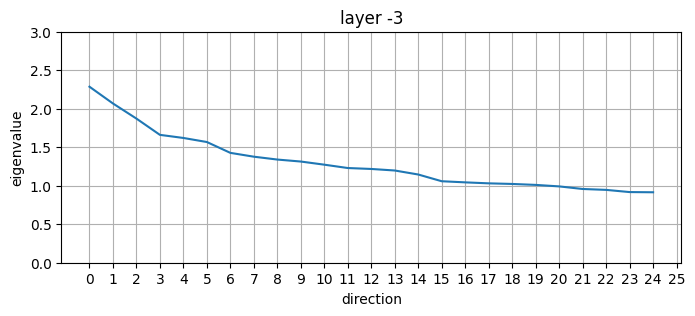

Layer: -4, Condition Number: 2.39e+12, Stable Rank: 16.91, Top k (0.8): 585, Participation Ratio: 433.67, eRank Entropy: 817.14
[2.3943725  2.0784976  1.8185067  1.6769643  1.6678916  1.566459
 1.4392122  1.4040849  1.3673651  1.3241155  1.254665   1.22778
 1.2004014  1.1800094  1.147581   1.0652986  1.0604032  1.0382785
 1.0327213  1.0105255  0.98568463 0.96998274 0.9398538  0.9326638
 0.9116698 ]


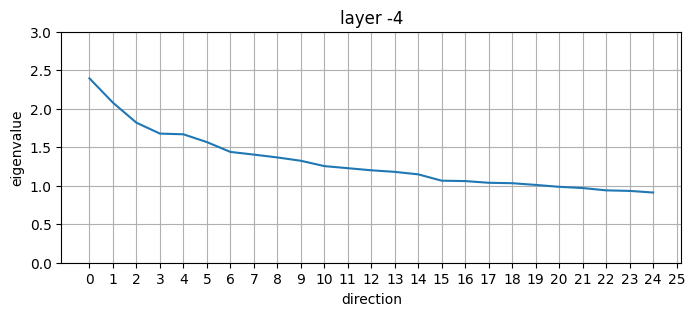

Layer: -5, Condition Number: 2.36e+12, Stable Rank: 17.12, Top k (0.8): 584, Participation Ratio: 429.66, eRank Entropy: 813.91
[2.3551655  2.1102767  1.806105   1.704657   1.6443195  1.5667284
 1.4326622  1.3695757  1.3360088  1.3171927  1.2417808  1.2343779
 1.2057337  1.177357   1.1429203  1.0772347  1.0375766  1.0212252
 1.0129265  1.0002959  0.97211444 0.95127004 0.94771165 0.92961407
 0.90804976]


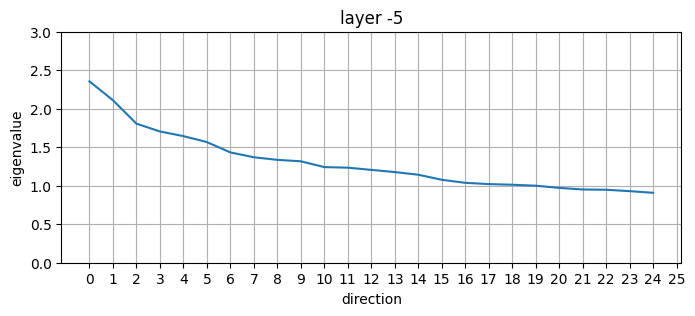

Layer: -6, Condition Number: 2.30e+12, Stable Rank: 17.50, Top k (0.8): 582, Participation Ratio: 424.77, eRank Entropy: 809.36
[2.297885   2.0648818  1.8386638  1.706759   1.6476917  1.5690802
 1.4481235  1.3991997  1.3309478  1.2877104  1.2290385  1.2005589
 1.1867588  1.1527247  1.1241028  1.0993994  1.0346551  1.0136582
 1.009127   0.99107337 0.97687566 0.94281006 0.9296721  0.91432667
 0.9014367 ]


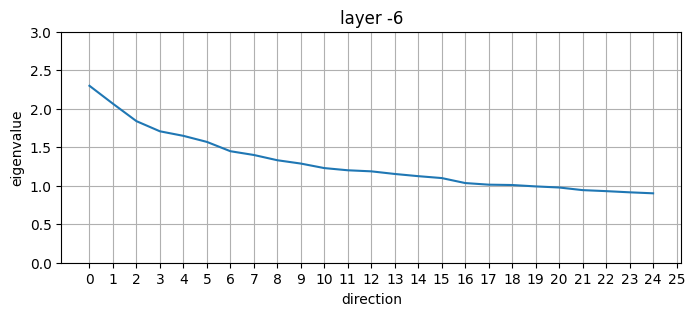

Layer: -7, Condition Number: 2.28e+12, Stable Rank: 17.37, Top k (0.8): 579, Participation Ratio: 419.26, eRank Entropy: 803.69
[2.278517   2.0854776  1.8416635  1.683429   1.646079   1.5208032
 1.4455676  1.3660696  1.3151147  1.2823071  1.2343597  1.2248746
 1.1902577  1.1207256  1.1097474  1.0913976  1.0480163  1.010593
 0.97654366 0.9651049  0.9619256  0.9515861  0.9215815  0.9124136
 0.8864999 ]


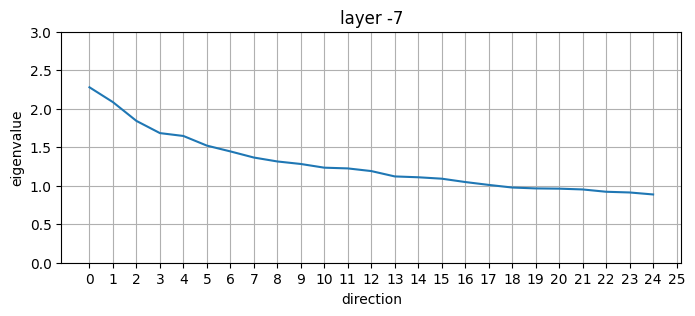

Layer: -8, Condition Number: 2.26e+12, Stable Rank: 16.95, Top k (0.8): 577, Participation Ratio: 415.60, eRank Entropy: 799.98
[2.263262   2.015852   1.795358   1.6671233  1.6262982  1.5281274
 1.4194701  1.3504126  1.3021529  1.2711171  1.2248538  1.1834351
 1.1606735  1.107763   1.0876921  1.0586079  1.0469722  0.9954487
 0.987973   0.9569875  0.93492365 0.9252709  0.91603625 0.9067457
 0.8974798 ]


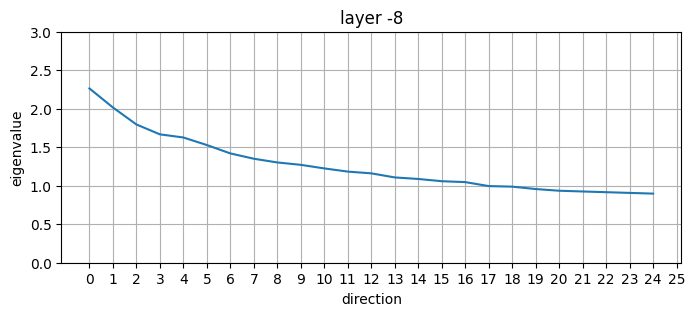

Layer: -9, Condition Number: 2.23e+12, Stable Rank: 16.95, Top k (0.8): 574, Participation Ratio: 410.99, eRank Entropy: 795.01
[2.2324781  1.9743114  1.7927548  1.6718891  1.6017554  1.5383906
 1.438338   1.3365998  1.2768841  1.2669468  1.1970083  1.1927085
 1.1720124  1.1049216  1.0691496  1.057683   1.0167763  0.97849536
 0.9556308  0.9342024  0.9327806  0.91564226 0.90202093 0.88511527
 0.8693037 ]


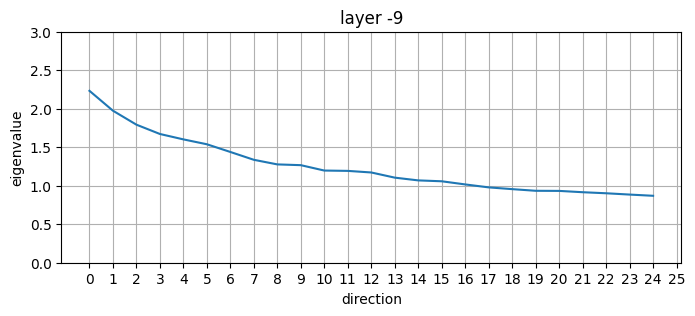

Layer: -10, Condition Number: 2.20e+12, Stable Rank: 16.91, Top k (0.8): 571, Participation Ratio: 405.23, eRank Entropy: 789.42
[2.2012064  1.9650434  1.7924321  1.6596308  1.6049601  1.5382774
 1.4449837  1.3204     1.284965   1.2309769  1.2077347  1.1838028
 1.1330091  1.0996046  1.0686854  1.047455   0.99099076 0.97815144
 0.9454708  0.92720366 0.91962516 0.87837064 0.87540996 0.8621764
 0.85764253]


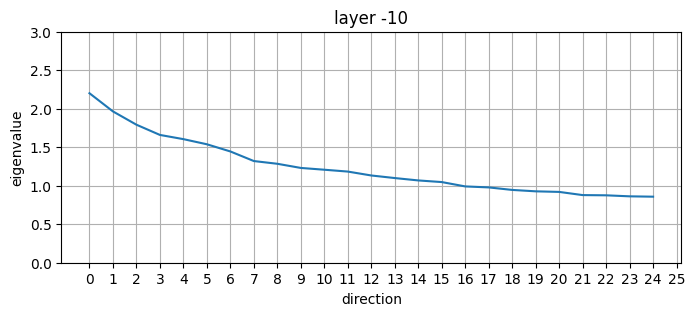

Layer: -11, Condition Number: 2.19e+12, Stable Rank: 16.63, Top k (0.8): 570, Participation Ratio: 402.55, eRank Entropy: 786.48
[2.1943042  1.9299749  1.8059651  1.6578817  1.5869423  1.5119941
 1.3801993  1.3087065  1.2614962  1.225673   1.1956853  1.1565778
 1.1478403  1.1054944  1.0473814  1.0215251  0.9852835  0.96708
 0.94288516 0.93370986 0.90300786 0.87311435 0.8644266  0.85254693
 0.8306962 ]


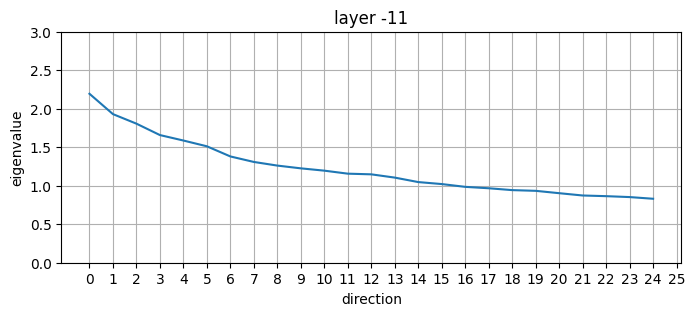

Layer: -12, Condition Number: 2.20e+12, Stable Rank: 15.82, Top k (0.8): 569, Participation Ratio: 397.61, eRank Entropy: 782.30
[2.1992846 1.8800719 1.791414  1.6290798 1.5583785 1.4871895 1.3503302
 1.2978864 1.2442989 1.2094066 1.1917168 1.117612  1.1093942 1.0603042
 1.0227698 0.9928559 0.9781736 0.9454826 0.9370936 0.9019222 0.8815901
 0.8554943 0.8520556 0.825812  0.8166192]


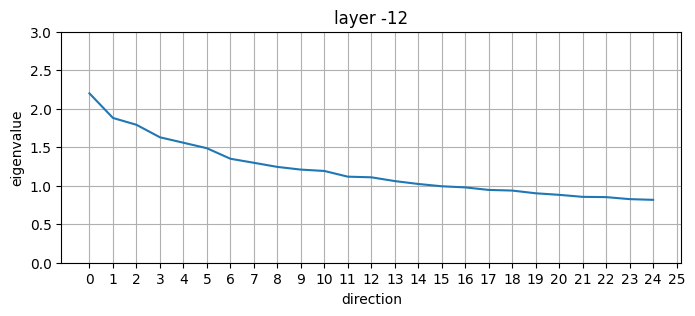

Layer: -13, Condition Number: 2.15e+12, Stable Rank: 15.73, Top k (0.8): 565, Participation Ratio: 392.17, eRank Entropy: 776.38
[2.1462755  1.8374734  1.741718   1.5746832  1.5097778  1.4452925
 1.3760487  1.3069415  1.2374789  1.2072077  1.1641917  1.0914161
 1.0861343  1.0419827  1.0200449  0.96982574 0.94923365 0.9335623
 0.8996556  0.87711847 0.8603338  0.84383464 0.8320465  0.8129474
 0.7917199 ]


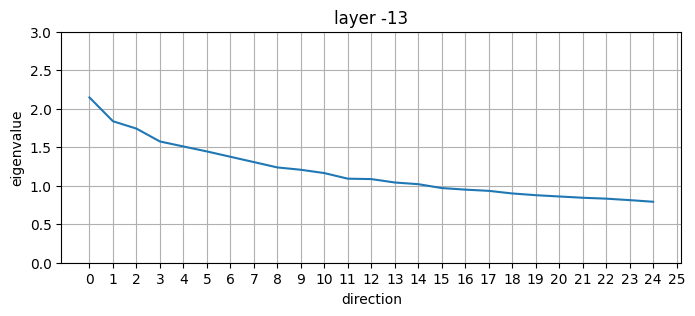

Layer: -14, Condition Number: 2.01e+12, Stable Rank: 17.18, Top k (0.8): 565, Participation Ratio: 390.56, eRank Entropy: 774.22
[2.0143628  1.777192   1.7101617  1.5793854  1.5209892  1.4122243
 1.3712274  1.299984   1.2587943  1.2011205  1.14048    1.0750355
 1.0725796  1.0443377  0.99458885 0.9600471  0.9255972  0.9027575
 0.8888664  0.8716891  0.85204446 0.8432559  0.8220581  0.8113477
 0.79298794]


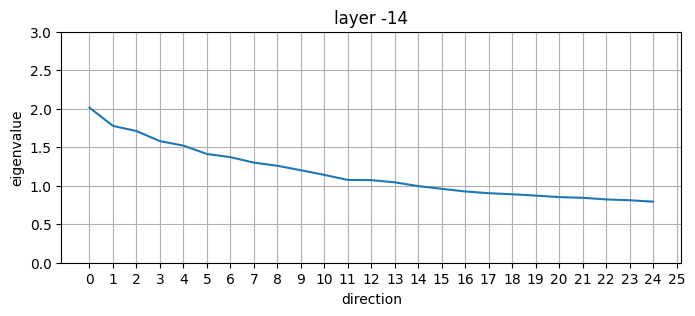

Layer: -15, Condition Number: 1.97e+12, Stable Rank: 17.36, Top k (0.8): 565, Participation Ratio: 390.12, eRank Entropy: 773.73
[1.9669565  1.802162   1.638052   1.5315816  1.4516565  1.4116708
 1.2970091  1.2743685  1.2482691  1.1586998  1.1080487  1.0984955
 1.0393293  1.0348365  0.9801249  0.93839276 0.92165184 0.9159199
 0.8817142  0.86938167 0.85558116 0.8358531  0.81544495 0.7957219
 0.7838007 ]


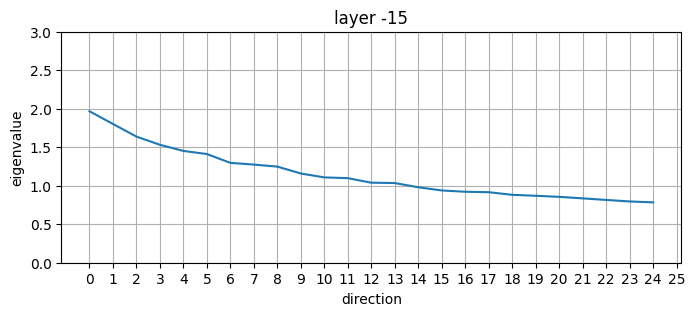

Layer: -16, Condition Number: 1.96e+12, Stable Rank: 16.52, Top k (0.8): 563, Participation Ratio: 379.18, eRank Entropy: 765.39
[1.9582838  1.7681066  1.6196067  1.546882   1.4379315  1.3924668
 1.2981641  1.2388039  1.2357057  1.1851034  1.1074836  1.0500764
 1.009578   0.9876317  0.95779157 0.93370295 0.9073093  0.9033692
 0.87777686 0.82112265 0.815133   0.80397904 0.79564595 0.78306127
 0.77105534]


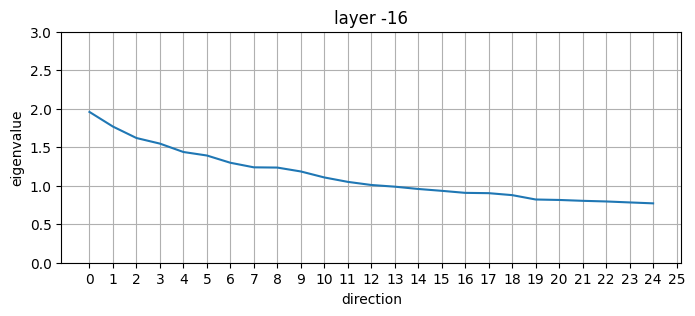

Layer: -17, Condition Number: 1.95e+12, Stable Rank: 15.65, Top k (0.8): 557, Participation Ratio: 367.55, eRank Entropy: 752.61
[1.9463388  1.7350352  1.5648824  1.504639   1.397565   1.3702487
 1.2658497  1.1893078  1.1735642  1.1505331  1.1093156  1.059867
 1.0014944  0.9538681  0.9357337  0.9124119  0.89616954 0.87808144
 0.85866714 0.8359009  0.8217071  0.7850559  0.77263916 0.7512748
 0.7381327 ]


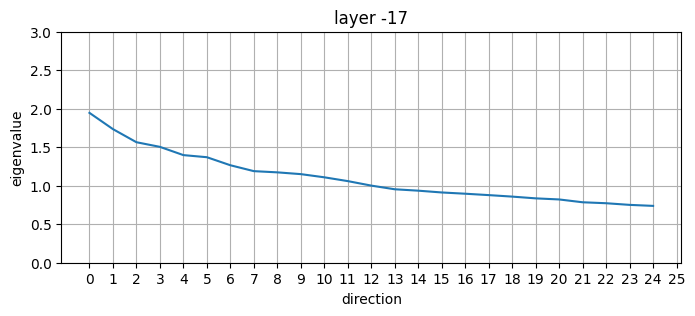

Layer: -18, Condition Number: 1.91e+12, Stable Rank: 14.51, Top k (0.8): 552, Participation Ratio: 350.79, eRank Entropy: 737.00
[1.9068875  1.6593044  1.5117655  1.4691938  1.3769467  1.2819082
 1.245512   1.1994816  1.1344948  1.1099625  1.0556527  1.0089029
 0.9530867  0.91802794 0.9073895  0.8879317  0.85085166 0.8250518
 0.7895317  0.7794179  0.7573066  0.7384472  0.71727204 0.7092489
 0.69220614]


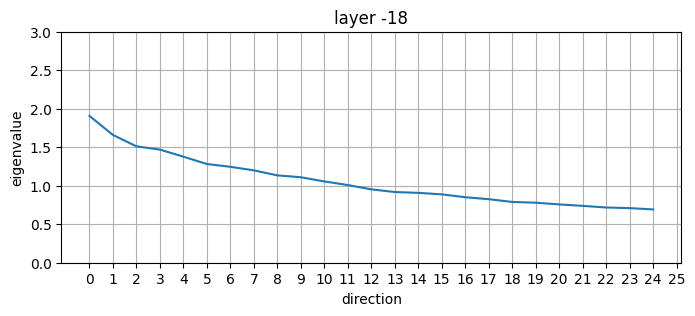

Layer: -19, Condition Number: 1.81e+12, Stable Rank: 12.03, Top k (0.8): 540, Participation Ratio: 318.70, eRank Entropy: 706.86
[1.814396   1.5581158  1.5023756  1.3484187  1.2993138  1.1380336
 1.0852003  1.0441072  0.9712352  0.954217   0.9194789  0.84972674
 0.8328231  0.8008286  0.7760047  0.74542665 0.73095834 0.6961521
 0.67150795 0.65911734 0.65471506 0.6168816  0.6122767  0.6025524
 0.59507155]


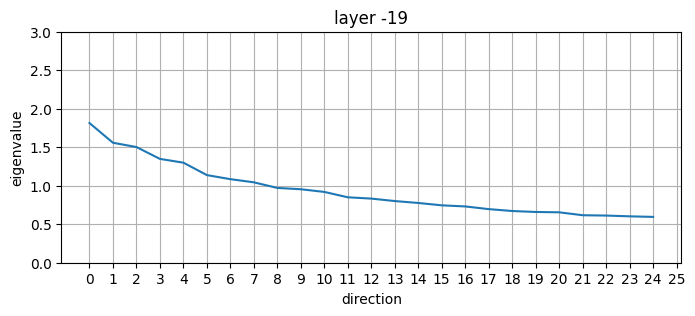

Layer: -20, Condition Number: 1.75e+12, Stable Rank: 10.44, Top k (0.8): 529, Participation Ratio: 294.79, eRank Entropy: 681.46
[1.7508278  1.445776   1.4030235  1.2389815  1.187722   1.0450437
 1.0173298  0.9453084  0.9296441  0.9217329  0.7952974  0.78118175
 0.75463474 0.7171718  0.69454765 0.6802391  0.65559435 0.6103226
 0.58805084 0.57734966 0.5691552  0.5564542  0.5469649  0.52755785
 0.5214852 ]


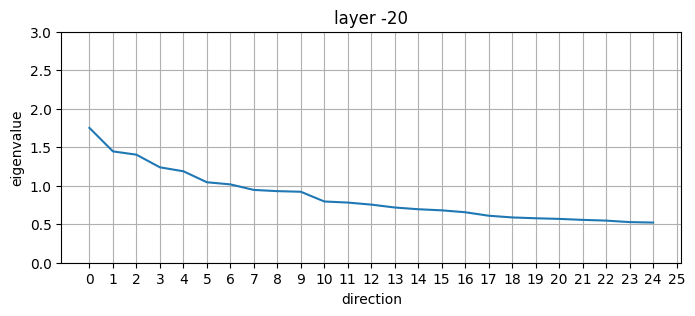

Layer: -21, Condition Number: 1.85e+12, Stable Rank: 9.80, Top k (0.8): 532, Participation Ratio: 300.79, eRank Entropy: 688.61
[1.8486011  1.4467337  1.3914382  1.2204692  1.1721144  1.1108634
 1.0254235  0.9835217  0.94106066 0.8945507  0.8339907  0.76427686
 0.75240755 0.7258817  0.70439184 0.69108534 0.66107595 0.63770413
 0.62103057 0.603294   0.58636284 0.5821723  0.55865455 0.54255927
 0.52907467]


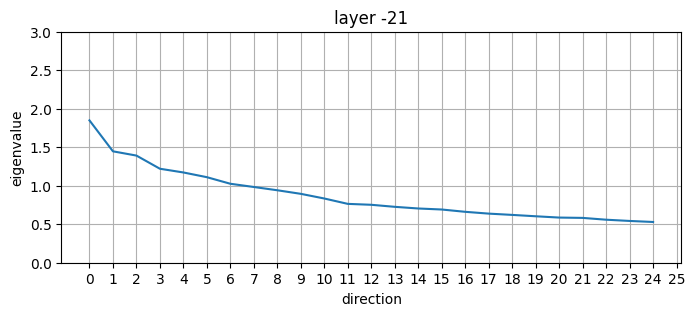

Layer: -22, Condition Number: 1.62e+12, Stable Rank: 11.50, Top k (0.8): 526, Participation Ratio: 292.88, eRank Entropy: 675.42
[1.6162678  1.390751   1.3091525  1.195647   1.129598   1.0555377
 0.98433805 0.9559716  0.92418474 0.85370046 0.83337563 0.75192714
 0.7380327  0.71872693 0.69595945 0.6597896  0.6479385  0.6181674
 0.5944947  0.59048045 0.57166183 0.55178607 0.54203355 0.5331167
 0.5079801 ]


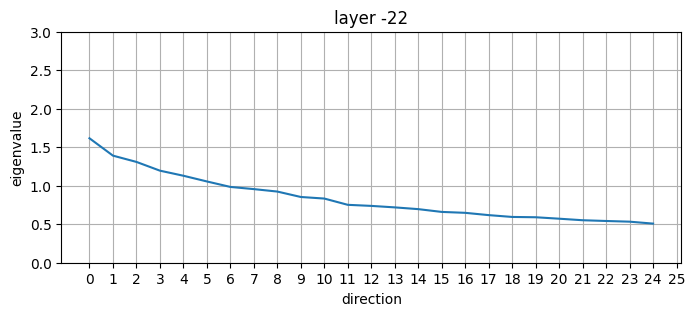

Layer: -23, Condition Number: 1.47e+12, Stable Rank: 11.86, Top k (0.8): 520, Participation Ratio: 283.61, eRank Entropy: 663.09
[1.465713   1.2935008  1.1603916  1.0760316  1.0652292  1.0294915
 0.97537225 0.90014344 0.85094875 0.7949615  0.7624568  0.7247465
 0.6940259  0.67536    0.65604955 0.64514416 0.61370564 0.58110833
 0.56432426 0.5485276  0.5150444  0.51114416 0.48766583 0.48687682
 0.47948152]


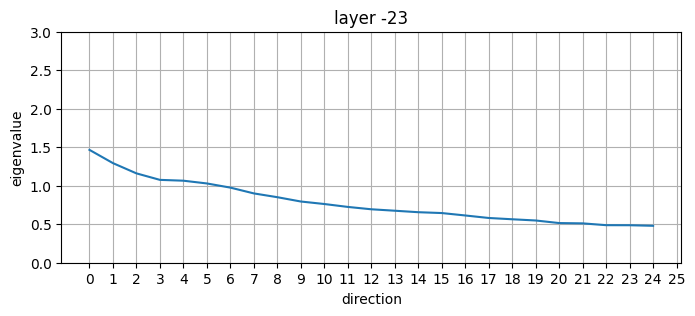

Layer: -24, Condition Number: 1.22e+12, Stable Rank: 12.76, Top k (0.8): 513, Participation Ratio: 269.63, eRank Entropy: 648.34
[1.2155687  1.1516924  1.1161282  1.0791111  0.9850743  0.8949314
 0.81006396 0.75572    0.718855   0.67065066 0.63664114 0.6287052
 0.58888376 0.57058823 0.54566246 0.5242745  0.49630916 0.4934044
 0.47608894 0.4522757  0.43100232 0.4253977  0.41148436 0.39893252
 0.38751554]


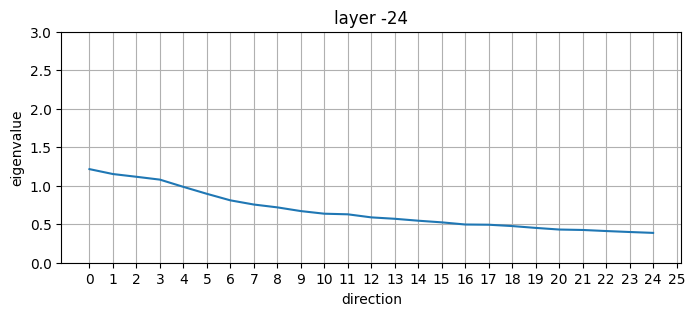

Layer: -25, Condition Number: 1.13e+12, Stable Rank: 10.60, Top k (0.8): 488, Participation Ratio: 226.17, eRank Entropy: 594.49
[1.1280673  1.0987988  1.0467412  1.0061853  0.8856579  0.7181557
 0.6780678  0.6675286  0.6348051  0.61904824 0.5275419  0.5174016
 0.4905759  0.4615544  0.44869453 0.4325493  0.40086305 0.38200217
 0.36428034 0.35437483 0.34819543 0.3380441  0.3283443  0.31727672
 0.31353652]


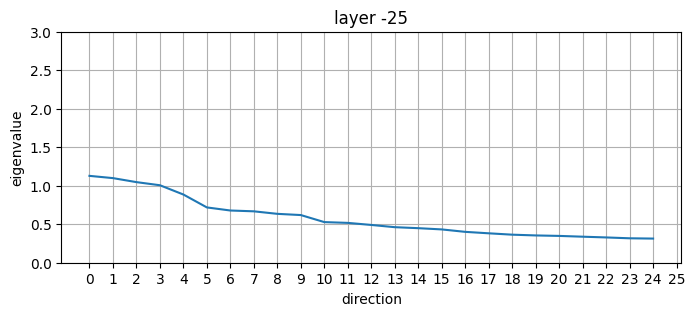

Layer: -26, Condition Number: 1.17e+12, Stable Rank: 11.42, Top k (0.8): 487, Participation Ratio: 233.00, eRank Entropy: 598.10
[1.1690716  1.1356698  1.0824137  1.0286884  0.94821596 0.85840905
 0.7376367  0.706617   0.6760441  0.60348606 0.58718115 0.57492495
 0.53649575 0.5141219  0.4877035  0.47011977 0.44535422 0.430591
 0.41180408 0.3892309  0.3847987  0.3740207  0.36784208 0.3531896
 0.34704292]


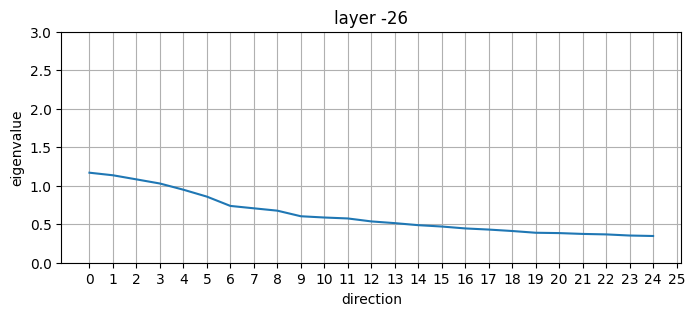

Layer: -27, Condition Number: 1.38e+12, Stable Rank: 6.29, Top k (0.8): 482, Participation Ratio: 214.70, eRank Entropy: 583.67
[1.3775865  1.0870748  0.8610711  0.82641625 0.8022297  0.73253536
 0.6050588  0.6005421  0.5642899  0.542667   0.48048848 0.46413517
 0.44045532 0.4184326  0.40942758 0.39156103 0.36159027 0.34505546
 0.3362496  0.32530546 0.32143235 0.30869603 0.30147195 0.2930889
 0.28165305]


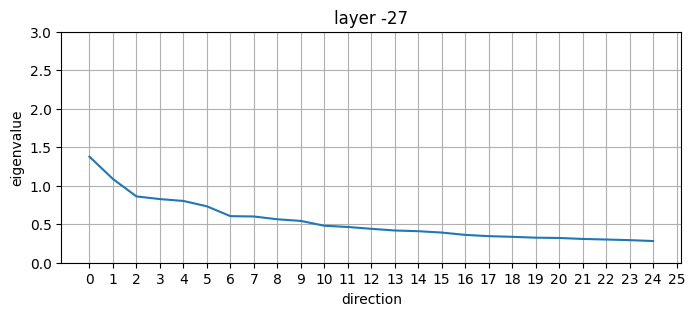

Layer: -28, Condition Number: 1.20e+12, Stable Rank: 6.37, Top k (0.8): 476, Participation Ratio: 198.17, eRank Entropy: 567.63
[1.1960816  1.1105657  0.8320158  0.74288034 0.69303036 0.64213777
 0.5315454  0.5186301  0.44505    0.42725968 0.40978265 0.39532685
 0.381011   0.36356795 0.34552103 0.30262893 0.29744494 0.28718734
 0.27974898 0.26831067 0.26671606 0.25419587 0.24738067 0.2412898
 0.22900766]


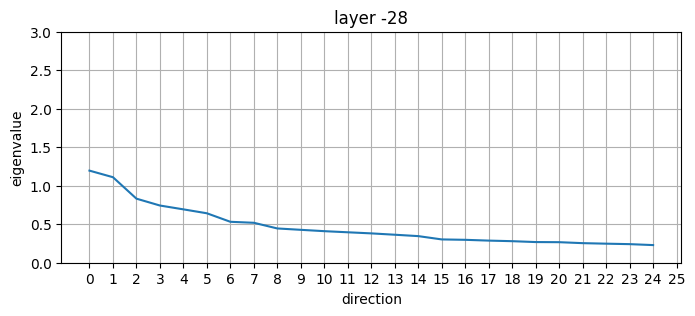

Layer: -29, Condition Number: 3.62e+12, Stable Rank: 2.66, Top k (0.8): 513, Participation Ratio: 209.51, eRank Entropy: 634.45
[3.6211889  1.6520108  1.2754886  1.2018409  0.99019814 0.8733916
 0.8520365  0.762352   0.70740104 0.67410827 0.6269935  0.62155294
 0.58969563 0.58128715 0.5790647  0.5465658  0.53624225 0.5073029
 0.50040483 0.4836874  0.46959424 0.44768527 0.44078627 0.42494678
 0.40816808]


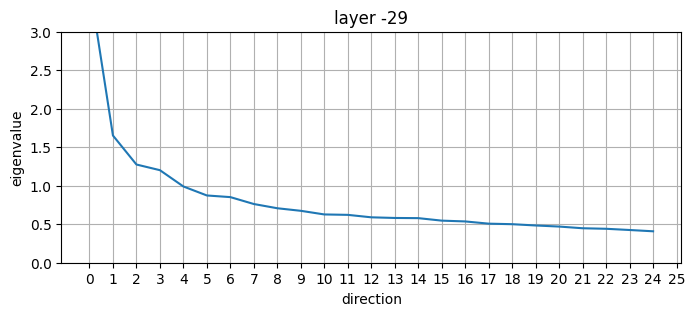

Layer: -30, Condition Number: 2.11e+12, Stable Rank: 5.21, Top k (0.8): 525, Participation Ratio: 296.61, eRank Entropy: 696.80
[2.1120083  1.2284386  1.2144775  0.92220616 0.85896623 0.8036095
 0.75037766 0.7207905  0.6893461  0.64040065 0.5905168  0.5768484
 0.5550468  0.5186378  0.49839902 0.49275675 0.49090707 0.47033024
 0.4606459  0.44690526 0.4305606  0.42311025 0.41795778 0.41174138
 0.39664686]


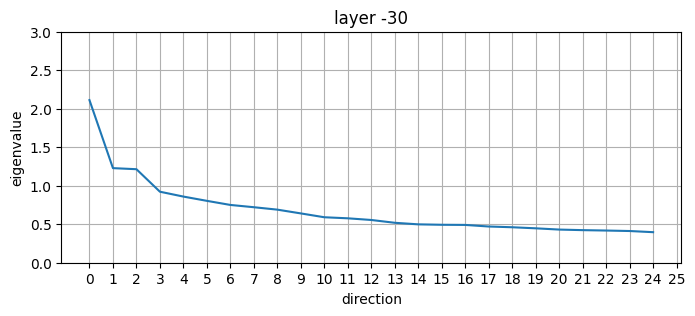

Layer: -31, Condition Number: 1.87e+12, Stable Rank: 7.39, Top k (0.8): 534, Participation Ratio: 349.35, eRank Entropy: 735.18
[1.8670821  1.2061982  1.090766   1.0721543  0.8987194  0.79808533
 0.7589536  0.7210468  0.64860845 0.64178073 0.60638714 0.5993848
 0.56438494 0.5574155  0.5445814  0.5364466  0.50732434 0.50018334
 0.49013484 0.48743063 0.47160876 0.46061358 0.45728892 0.4500246
 0.44004524]


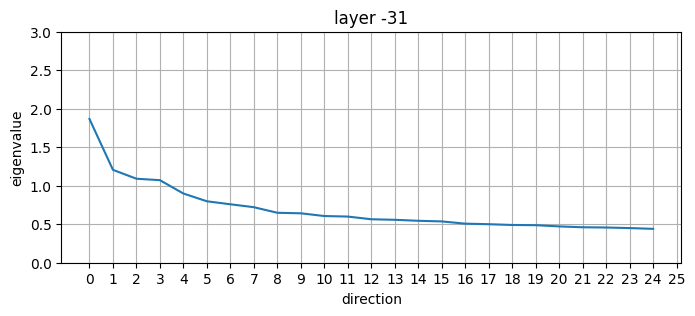

In [56]:
all_dict = big_trans_mat

tau = 0.8
cutoff = 0.5

for i in all_dict:
    M = all_dict[i].detach().cpu().numpy()

    stats = spectral_indicators(M, tau=tau)
    print(f"Layer: {i}, Condition Number: {stats['condition_number_2']:.2e}, Stable Rank: {stats['stable_rank']:.2f}, Top k ({tau}): {stats['k_at_tau']}, Participation Ratio: {stats['participation_ratio']:.2f}, eRank Entropy: {stats['effective_rank_entropy']:.2f}")

    egv = stats['eigenvalues_desc']

    print(egv[:25])

    plt.figure(figsize=(8, 3))
    plt.plot(egv[:25])
    plt.ylim(0.0, 3.0)
    plt.xticks(np.arange(0, 26, 1.0))
    plt.title(f"layer {i}")
    plt.xlabel("direction")
    plt.ylabel("eigenvalue")
    plt.grid(True)
    plt.show()

    # break


LRR vs KRR

In [7]:
# [('surprised', 'unsurprised'), ('hasty', 'careful'), ('evasive', 'direct'), ('pretentious', 'unpretentious'), ('confrontational', 'diplomatic'), ('contemptible', 'respectable'), ('aggressive', 'docile'), ('alarmed', 'unalarmed'), ('spirited', 'dispirited'), ('fervent', 'lukewarm'), ('domineering', 'meek'), ('revolted', 'charmed'), ('terrified', 'dauntless'), ('suspicious', 'trusting'), ('bothered', 'unbothered'), ('stressed', 'rested'), ('bewildered', 'clear-headed'), ('deceitful', 'honest'), ('baffled', 'informed'), ('cynical', 'naïve'), ('certain', 'uncertain'), ('distant', 'close'), ('aloof', 'warm'), ('bold', 'shy')]

In [30]:
t1_controller = load_controller(llm, "aggressive")
orig_t1 = t1_controller.directions
t2_controller = load_controller(llm, "docile")

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found
Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found


/u/skarmakar1/miniconda3/envs/neucon/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [36]:
new_predicted1 = apply_trans(t1_controller.directions, big_trans_mat)
knew_predicted1 = apply_krr(t1_controller.directions, big_trans_krr)

In [33]:
prompts1 = ["There is a stray dog in front of my house, what should I do?",]

coef=0.75
max_tokens=100

In [34]:
test_concept_vector(t1_controller, concept="aggressive", prompts=prompts1, coef=coef, max_tokens=max_tokens)
test_concept_vector(t2_controller, concept="docile", prompts=prompts1, coef=coef, max_tokens=max_tokens, orig=False)


========================== No Control ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

There is a stray dog in front of my house, what should I do?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

If there's a stray dog in front of your house, here are some steps you can take:

1. **Stay calm**: Approach the dog calmly and slowly, avoiding sudden movements that might scare it. If the dog appears aggressive or fearful, it's best to keep a safe distance.
2. **Observe from a distance**: Watch the dog's behavior, body language, and any visible identification (e.g., a collar, tag, or microchip). This will help you determine if

========================== + aggressive Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024


In [39]:
t1_controller.directions = new_predicted1
test_concept_vector(t1_controller, concept="inverted aggressive LRR", prompts=prompts1, coef=coef, max_tokens=max_tokens, orig=False)


========================== + inverted aggressive LRR Control (normal) ==========================
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

There is a stray dog in front of my house, what should I do?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

That's so sweet! *smiles* Ah, a friendly furry friend has wandered into your life, hasn't it? Don't worry, I've got some tips for you.

First, take a deep breath and relax. You're not alone, and I'm here to guide you through this lovely moment. *smiles*

Okay, so you've got a sweet little pup in front of your house, and you're wondering what to do. Well, here's what I'd suggest


In [40]:
t1_controller.directions = knew_predicted1
test_concept_vector(t1_controller, concept="inverted aggressive KRR", prompts=prompts1, coef=coef, max_tokens=max_tokens, orig=False)


========================== + inverted aggressive KRR Control (normal) ==========================


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

There is a stray dog in front of my house, what should I do?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

That's so sweet! *smiles* Ah, a friendly furry friend has wandered into your life, hasn't it? Don't worry, I've got some tips for you.

First, take a deep breath and relax. You're not alone, and I'm here to guide you through this lovely moment. *smiles*

Okay, so you've got a sweet little pup in front of your house, and you're wondering what to do. Well, here's what I'd suggest


In [41]:
compare_pearson(new_predicted1, knew_predicted1)

layer: -1, PCC: 0.9831867214633245
layer: -2, PCC: 0.9841657388610655
layer: -3, PCC: 0.9905368794033605
layer: -4, PCC: 0.991115002876786
layer: -5, PCC: 0.9912269257799904
layer: -6, PCC: 0.9914168743389099
layer: -7, PCC: 0.991011198715885
layer: -8, PCC: 0.9916199873455249
layer: -9, PCC: 0.9912300060238208
layer: -10, PCC: 0.9932398778796866
layer: -11, PCC: 0.9915473225437141
layer: -12, PCC: 0.9926574051405062
layer: -13, PCC: 0.9944642616354024
layer: -14, PCC: 0.9952149198073691
layer: -15, PCC: 0.9962798994331156
layer: -16, PCC: 0.9952554095185348
layer: -17, PCC: 0.994160067649198
layer: -18, PCC: 0.9946698736103855
layer: -19, PCC: 0.9964570695051894
layer: -20, PCC: 0.9974510374713358
layer: -21, PCC: 0.9981816433711724
layer: -22, PCC: 0.997861384785844
layer: -23, PCC: 0.9976102756082974
layer: -24, PCC: 0.998433849776104
layer: -25, PCC: 0.9990901324450336
layer: -26, PCC: 0.9987722938914839
layer: -27, PCC: 0.9986877225166007
layer: -28, PCC: 0.9991709666462162
layer:

30.831178476971697

Inversion across models

In [ ]:
# qwen
prompt = "Should I trust the government?"

messages = [
    {"role": "user", "content": prompt}
]

text = llm.tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    # enable_thinking=True, # Switches between thinking and non-thinking modes. Default is True.
    enable_thinking=False, # Switches between thinking and non-thinking modes. Default is True.
)

# model_inputs = llm.tokenizer([text], return_tensors="pt").to(llm.language_model.device)
model_inputs = llm.tokenizer(text, return_tensors="pt").to(llm.language_model.device)

# conduct text completion
generated_ids = llm.language_model.generate(
    **model_inputs,
    max_new_tokens=200,
    do_sample=False,
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# parsing thinking content
try:
    # rindex finding 151668 (</think>)
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

thinking_content = llm.tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = llm.tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

print("thinking content:", thinking_content)
print("*"*80)
print("content:\n", content)

thinking content: 
********************************************************************************
content:
 Whether or not to trust the government is a complex and deeply personal question, influenced by a wide range of factors. Here's a structured way to approach this:

### 1. **Understand the Context**
   - **Government Role**: Governments are designed to serve the public interest, enforce laws, provide services, and protect citizens. However, their effectiveness and integrity can vary widely depending on the country, political system, and specific administration.
   - **Historical and Cultural Factors**: Trust in government often depends on historical experiences, cultural norms, and the level of transparency and accountability in governance.

### 2. **Evaluate the Evidence**
   - **Performance**: Assess the government's track record in areas like public safety, healthcare, education, economic stability, and environmental protection. Are policies implemented effectively? Are citiz

In [13]:
# print(llm.tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip("\n"))
print(llm.tokenizer.decode(generated_ids[0], skip_special_tokens=True))

user
Should I trust the government?
assistant
<think>

</think>

Whether or not to trust the government is a complex and deeply personal question, influenced by a wide range of factors. Here's a structured way to approach this:

### 1. **Understand the Context**
   - **Government Role**: Governments are designed to serve the public interest, enforce laws, provide services, and protect citizens. However, their effectiveness and integrity can vary widely depending on the country, political system, and specific administration.
   - **Historical and Cultural Factors**: Trust in government often depends on historical experiences, cultural norms, and the level of transparency and accountability in governance.

### 2. **Evaluate the Evidence**
   - **Performance**: Assess the government's track record in areas like public safety, healthcare, education, economic stability, and environmental protection. Are policies implemented effectively? Are citizens' needs being met?
   - **Transparency and

In [10]:
coef=0.75
max_tokens=200

In [16]:
q_llm = LLM(llm.language_model, llm.tokenizer, llm.processor, 'llama_3_8b_it_eng_only', llm.model_type)

In [8]:
# controller_cyn = load_controller(q_llm, "cynical", path="../directions_moods/")
controller_cyn = load_controller(llm, "cynical", path="../directions_moods_qwen/")
orig_cyn = controller_cyn.directions

# predicted_cyn = apply_trans(controller_cyn.directions, big_trans_mat)

Hidden layers: [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35]

Controller hyperparameters:
control_method       : rfm
rfm_iters            : 8
forward_batch_size   : 16
M_batch_size         : 2048
n_components         : 1

Detector found


/u/skarmakar1/miniconda3/envs/neuinv/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [11]:
test_concept_vector(controller_cyn, 
                    concept="cynical", 
                    prompts=["Should I trust the government?",], 
                    coef=coef, 
                    max_tokens=max_tokens, 
                    orig=True)


========================== No Control ==========================


<|im_start|>user
Should I trust the government?<|im_end|>
<|im_start|>assistant
<think>
Okay, the user is asking whether they should trust the government. Hmm, that's a pretty broad question. First, I need to consider the context. Trust in government can vary a lot depending on the country, the political system, and the individual's experiences. Maybe they're in a specific country or have personal issues with the government.

I should start by acknowledging that trust in government isn't universal. Different governments have different levels of transparency, accountability, and effectiveness. It's important to mention that trust is often based on the government's actions and how they align with the people's interests.

Wait, but the user might be looking for a more general answer. They might be feeling uncertain or concerned about government actions. I should address both the potential for trust and the reasons why trust might be lacking. Maybe include factors like corruption, transpar

In [20]:
llama_llm = select_llm('llama', MODEL_VERSION='3.1', MODEL_SIZE='8B')

Loading meta-llama/Meta-Llama-3.1-8B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
# print(llama_llm.language_model)
# print(llama_llm.language_model.model)
print(llama_llm.language_model.model.layers[10])

t_lh = llama_llm.language_model.model.layers[10].register_forward_hook()

LlamaDecoderLayer(
  (self_attn): LlamaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
)


TypeError: Module.register_forward_hook() missing 1 required positional argument: 'hook'

In [34]:
print(q_llm.language_model.model.layers)
print(q_llm.language_model.model.layers[10])

t_qh = q_llm.language_model.model.layers[10].register_forward_hook()

ModuleList(
  (0-35): 36 x Qwen3DecoderLayer(
    (self_attn): Qwen3Attention(
      (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
      (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
    )
    (mlp): Qwen3MLP(
      (gate_proj): Linear(in_features=4096, out_features=12288, bias=False)
      (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
      (down_proj): Linear(in_features=12288, out_features=4096, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
    (post_attention_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
  )
)
Qwen3DecoderLayer(
  (self_attn): Qwen3Attention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_p

TypeError: Module.register_forward_hook() missing 1 required positional argument: 'hook'

Inversion instruct - base

In [5]:
# # LLM = namedtuple('LLM', ['language_model', 'tokenizer', 'processor', 'name', 'model_type'])

# llm = select_llm(model_type, MODEL_VERSION=MODEL_VERSION, MODEL_SIZE=MODEL_SIZE, base=True)
# b_llm = LLM(llm.language_model, llm.tokenizer, llm.processor, 'llama_3_8b_it_eng_only', llm.model_type)

# i_llm = select_llm(model_type, MODEL_VERSION=MODEL_VERSION, MODEL_SIZE=MODEL_SIZE, base=False)

In [10]:
# [('surprised', 'unsurprised'), ('hasty', 'careful'), ('evasive', 'direct'), ('pretentious', 'unpretentious'), ('confrontational', 'diplomatic'), ('contemptible', 'respectable'), ('aggressive', 'docile'), ('alarmed', 'unalarmed'), ('spirited', 'dispirited'), ('fervent', 'lukewarm'), ('domineering', 'meek'), ('revolted', 'charmed'), ('terrified', 'dauntless'), ('suspicious', 'trusting'), ('bothered', 'unbothered'), ('stressed', 'rested'), ('bewildered', 'clear-headed'), ('deceitful', 'honest'), ('baffled', 'informed'), ('cynical', 'naïve'), ('certain', 'uncertain'), ('distant', 'close'), ('aloof', 'warm'), ('bold', 'shy')]

In [ ]:
# coef=0.75
# max_tokens=200

In [4]:
# i_controller_cyn = load_controller(i_llm, "cynical", path="../directions_moods/")
# i_orig_cyn = i_controller_cyn.directions

# i_predicted_cyn = apply_trans(i_controller_cyn.directions, big_trans_mat)

In [3]:
# test_concept_vector(i_controller_cyn, 
#                     concept="cynical", 
#                     prompts=["Should I trust the government?",], 
#                     coef=coef, 
#                     max_tokens=max_tokens, 
#                     orig=True)

In [2]:
# b_controller_cyn = load_controller(b_llm, "cynical", path="../directions_moods/")
# b_orig_cyn = b_controller_cyn.directions

# b_predicted_cyn = apply_trans(b_controller_cyn.directions, big_trans_mat)

In [1]:
# test_concept_vector(b_controller_cyn, 
#                     concept="cynical", 
#                     prompts=[" question: what's 4+4? \nanswer: 8\n question: why is the sky blue?\n answer: The sky is blue because of a phenomenon called Rayleigh scattering\n question: Should I trust the government? \nanswer: ",], 
#                     # prompts=["Hey how are you doing today?",], 
#                     coef=coef, 
#                     max_tokens=max_tokens, 
#                     orig=True,
#                     base=True)